In [1]:
import sys
import os
import numpy as np
import time
from datetime import timedelta
import scipy.io
import gc


# Record the overall start time
general_start_time = time.time()

# Get absolute path of project root (one level above current directory)
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
# Add project root to sys.path to import modules from other project folders
if project_root not in sys.path:
    sys.path.append(project_root)

%load_ext autoreload
%autoreload 2

from utils.system_info import print_system_info
print_system_info()

import tensorflow as tf
tf.disable_v2_behavior()

# Configure GPU for training (use TensorFlow v1.9 for CuDNNLSTM)
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'  # CPU: -1; GPU0: 1; GPU1: 0


------------------------------------------------------------
System and runtime environment information:
 Execution date and time : 2025-07-02 02:07:25
- Virtual environment    : multiphylstm
- OS Kernel              : Linux - Release 6.8.0-62-generic (#65-Ubuntu SMP PREEMPT_DYNAMIC Mon May 19 17:15:03 UTC 2025)
- OS Distribution        : Ubuntu 24.04.2 LTS
- CPU                    : 12th Gen Intel(R) Core(TM) i5-12400
- GPU 0                  : NVIDIA GeForce RTX 3060
  ↳ Total memory         : 12288 MB
  ↳ Used memory          : 167 MB
  ↳ Free memory          : 11754 MB
- Python version         : 3.6.13
- TensorFlow             : 1.15.5
- Keras                  : 2.2.4-tf

- Current directory      : /home/fermandoislab/Desktop/Proyecto PINNs/Dev-PINNs-for-Nonlinear-Dynamic-Structural-Response/notebooks


In [2]:
# List of variables to keep in the global namespace
keep_vars = {
    # Imported modules
    'gc', 'sys', 'os', 'np', 'time', 'timedelta', 'scipy', 'tf',

    # Project-specific configuration
    'general_start_time', 'project_root',

    # Results or data you want to keep
    'total_runtime_model_1', 'df_summary_formatted_1',
    'total_runtime_model_2', 'df_summary_formatted_2',
    'total_runtime_model_3', 'df_summary_formatted_3',

    # Functions to keep
    'keep_vars'
}

# Function to delete all other variables except those specified in keep_vars
def delete_all_other_variables(keep_vars):
    """
    Deletes all variables from the global environment except those specified in keep_vars.
    Args:
        keep_vars (set): A set of variable names to keep in the global environment.
    """
    
    # Essential internal IPython variables to avoid deleting
    ipython_vars = {
        'In', 'Out', '_i', '_ii', '_iii', '_ih', '_oh', '_', '__', '___',
        'get_ipython', 'exit', 'quit'
    }

    # Delete all other variables from the global environment
    for var_name in list(globals()):
        if (var_name not in keep_vars and 
           var_name not in ipython_vars and 
           not var_name.startswith("__") and 
           var_name != 'delete_all_other_variables'):
            # Attempt to delete the variable
            del globals()[var_name]

    # Run garbage collection
    collected = gc.collect()
    print(f"Memory cleaned. Objects collected: {collected}")
    return collected


---
# Model 1: PhyLSTM-2 on Bouc-Wen SDOF
---

## Model Definition

In [ ]:
# Type of PhyCNN model ('PhyLSTM-2' or 'PhyLSTM-3')
model_type_1 = 'PhyLSTM-2'

# Dataset identifier
data_base_1 = 'BoucWen Data'

# Number of training epochs
epochs_1 = 3#5000

# Use BFGS optimization for training after initial training
use_bfgs_1 = 1 # Use BFGS optimization for training

# Batch size for training
n_data_train_1 = 10

# Number of collocation samples
n_data_collocation_1 = 50

# Step size for downsampling the input data
downsample_step_1 = 1  # The original code does not specify this

# Record the start time for Model 1’s training
model_1_start_time = time.time()

# Define path to store results
results_path_1 = project_root + '/results/results_phylstm/phylstm2_boucwen'
os.makedirs(results_path_1, exist_ok=True)

# Define path to save the best model for Model 1
model_path_1 = results_path_1 + '/my_best_model_phylstm2_boucwen.h5'

# Define path to save the results for Model 1
result_file_path_1 = results_path_1 + '/results_PhyLSTM2_boucwenSDOF.mat'

## Load Data: Bouc-Wen Data

In [4]:
# Load MATLAB data file
mat_1 = scipy.io.loadmat(project_root + '/data/raw/data_boucwen.mat')

# Optional: inspect available variables
print(mat_1.keys())

dict_keys(['__header__', '__version__', '__globals__', 'Ind_P', 'Ind_TV', 'input_pred_tf', 'input_tf', 'target_X_tf', 'target_Xd_tf', 'target_Xdd_tf', 'target_pred_X_tf', 'target_pred_Xd_tf', 'target_pred_Xdd_tf', 'time', 'trainInd', 'valInd'])


In [5]:
# Print available variable shapes
print('-' * 100)
print(f"input_tf          : {str(mat_1['input_tf'].shape):<15} → Inputs for training/validation (e.g., ground accelerations).")
print(f"target_X_tf       : {str(mat_1['target_X_tf'].shape):<15} → Displacement targets for training/validation.")
print(f"target_Xd_tf      : {str(mat_1['target_Xd_tf'].shape):<15} → Velocity targets for training/validation.")
print(f"target_Xdd_tf     : {str(mat_1['target_Xdd_tf'].shape):<15} → Acceleration targets for training/validation.")
print(f"input_pred_tf     : {str(mat_1['input_pred_tf'].shape):<15} → Inputs for prediction (unseen ground accelerations).")
print(f"target_pred_X_tf  : {str(mat_1['target_pred_X_tf'].shape):<15} → True displacements for prediction.")
print(f"target_pred_Xd_tf : {str(mat_1['target_pred_Xd_tf'].shape):<15} → True velocities for prediction.")
print(f"target_pred_Xdd_tf: {str(mat_1['target_pred_Xdd_tf'].shape):<15} → True accelerations for prediction.")
print(f"time              : {str(mat_1['time'].shape):<15} → Time vector for inputs/outputs.(in seconds)")
print(f"Ind_TV            : {str(mat_1['Ind_TV'].shape):<15} → Indices for Train+Val set.")
print(f"Ind_P             : {str(mat_1['Ind_P'].shape):<15} → Indices for Prediction set. (Test set)")
print(f"trainInd          : {str(mat_1['trainInd'].shape):<15} → Indices for training set.")
print(f"valInd            : {str(mat_1['valInd'].shape):<15} → Indices for validation set.")
print('-' * 100)

----------------------------------------------------------------------------------------------------
input_tf          : (85, 1501)      → Inputs for training/validation (e.g., ground accelerations).
target_X_tf       : (85, 1501)      → Displacement targets for training/validation.
target_Xd_tf      : (85, 1501)      → Velocity targets for training/validation.
target_Xdd_tf     : (85, 1501)      → Acceleration targets for training/validation.
input_pred_tf     : (15, 1501)      → Inputs for prediction (unseen ground accelerations).
target_pred_X_tf  : (15, 1501)      → True displacements for prediction.
target_pred_Xd_tf : (15, 1501)      → True velocities for prediction.
target_pred_Xdd_tf: (15, 1501)      → True accelerations for prediction.
time              : (1, 1501)       → Time vector for inputs/outputs.(in seconds)
Ind_TV            : (1, 85)         → Indices for Train+Val set.
Ind_P             : (1, 15)         → Indices for Prediction set. (Test set)
trainInd          : (

Define loaded data with known variable names

In [ ]:
# Extract and reshape data
ag_data_1 = mat_1['input_tf'][: ,::downsample_step_1]       # external acceleration
u_data_1 = mat_1['target_X_tf'][: ,::downsample_step_1]     # floor displacement 
ut_data_1 = mat_1['target_Xd_tf'][: ,::downsample_step_1]   # floor velocity
utt_data_1 = mat_1['target_Xdd_tf'][: ,::downsample_step_1] # floor acceleration

# Reshape to [samples, timesteps, 1]
ag_data_1 = ag_data_1.reshape([ag_data_1.shape[0], ag_data_1.shape[1], 1])
u_data_1 = u_data_1.reshape([u_data_1.shape[0], u_data_1.shape[1], 1])
ut_data_1 = ut_data_1.reshape([ut_data_1.shape[0], ut_data_1.shape[1], 1])
utt_data_1 = utt_data_1.reshape([utt_data_1.shape[0], utt_data_1.shape[1], 1])

# Time vector
t = mat_1['time']
dt = t[0, 1] - t[0, 0]
t_1 = t[:,::downsample_step_1]
dt_1 = t_1[0, 1] - t_1[0, 0]

# Assign for convenience
ag_all_1 = ag_data_1
u_all_1 = u_data_1
u_t_all_1 = ut_data_1
u_tt_all_1 = utt_data_1

# Print shape information
print(f"t           : {t.shape} → Original time vector.")
print(f"dt          : {dt} s    → Original time step.")
print('-' * 100)
print(f"t_1         : {t_1.shape} → Downsampled time vector.")
print(f"dt_1        : {dt_1} s   → Downsampled time step.")
print(f"ag_data_1   : {ag_data_1.shape} → Ground accelerations (inputs).")
print(f"u_data_1    : {u_data_1.shape} → Floor displacements (outputs).")
print(f"ut_data_1   : {ut_data_1.shape} → Floor velocities (outputs).")
print(f"utt_data_1  : {utt_data_1.shape} → Floor accelerations (outputs).")
print('-' * 100)

ag_all_1   : (85, 1501, 1) → Ground accelerations (inputs).
u_all_1    : (85, 1501, 1) → Floor displacements (outputs).
u_t_all_1  : (85, 1501, 1) → Floor velocities (outputs).
u_tt_all_1 : (85, 1501, 1) → Floor accelerations (outputs).
t_1        : (1, 1501) → Time vector.
dt_1       : 0.02 s → Time step.
----------------------------------------------------------------------------------------------------


In [ ]:
# Extract and reshape data
ag_pred_1 = mat_1['input_pred_tf'][: ,::downsample_step_1]       # external acceleration
u_pred_1 = mat_1['target_pred_X_tf'][: ,::downsample_step_1]     # floor displacement 
ut_pred_1 = mat_1['target_pred_Xd_tf'][: ,::downsample_step_1]   # floor velocity
utt_pred_1 = mat_1['target_pred_Xdd_tf'][: ,::downsample_step_1] # floor acceleration

# Reshape to [samples, timesteps, 1]
ag_pred_1 = ag_pred_1.reshape([ag_pred_1.shape[0], ag_pred_1.shape[1], 1])
u_pred_1 = u_pred_1.reshape([u_pred_1.shape[0], u_pred_1.shape[1], 1])
ut_pred_1 = ut_pred_1.reshape([ut_pred_1.shape[0], ut_pred_1.shape[1], 1])
utt_pred_1 = utt_pred_1.reshape([utt_pred_1.shape[0], utt_pred_1.shape[1], 1])

# Print shape information
print(f"ag_pred_1   : {ag_pred_1.shape} → Ground accelerations for prediction on unseen data (inputs).")
print(f"u_pred_1    : {u_pred_1.shape} → Floor displacements for prediction on unseen data (outputs).")
print(f"ut_pred_1   : {ut_pred_1.shape} → Floor velocities for prediction on unseen data (outputs).")
print(f"utt_pred_1  : {utt_pred_1.shape} → Floor accelerations for prediction on unseen data (outputs).")
print('-' * 100)

ag_pred_2   : (15, 376, 1) → Ground accelerations for prediction on unseen data (inputs).
u_pred_2    : (15, 376, 1) → Floor displacements for prediction on unseen data (outputs).
ut_pred_2   : (15, 376, 1) → Floor velocities for prediction on unseen data (outputs).
utt_pred_2  : (15, 376, 1) → Floor accelerations for prediction on unseen data (outputs).
----------------------------------------------------------------------------------------------------


**Finite Difference Matrix for Time Derivatives**

To compute the time derivative of the displacement vector **u**, we define a finite difference matrix **$\Phi$** such that:

$$
    \frac{\partial u}{\partial t} = \Phi \, u
$$

Here, **$\Phi$** is a banded matrix that applies centered finite differences to approximate the time derivative. For a sequence of length $N$, the structure of **$\Phi$** is:

$$
\Phi =
\begin{pmatrix}
  -\tfrac{3}{2} & 2 & -\tfrac{1}{2} & 0 & \cdots & 0 \\
  0 & -\tfrac{1}{2} & 0 & \tfrac{1}{2} & \cdots & 0 \\
  0 & 0 & -\tfrac{1}{2} & 0 & \ddots & 0 \\
  \vdots & & & \ddots & \ddots & \tfrac{1}{2} \\
  0 & \cdots & 0 & -\tfrac{1}{2} & 0 & \tfrac{1}{2} \\
  0 & \cdots & 0 & -\tfrac{1}{2} & 2 & -\tfrac{3}{2}  
\end{pmatrix}
$$

* **First row**: a one-sided finite difference of order 2 to handle the boundary:
  $\Phi_{1,:} = [-\tfrac{3}{2}, \; 2, \; -\tfrac{1}{2}, \; 0, \; \dots]$
* **Interior rows** (from 2 to $N-1$): centered difference:
  $\Phi_{i,:} = [\dots, \; -\tfrac{1}{2}, \; 0, \; \tfrac{1}{2}, \; \dots]$
* **Last row**: one-sided of order 2 at the end:
  $\Phi_{N,:} = [\dots, \; 0, \; -\tfrac{1}{2}, \; 2, \; -\tfrac{3}{2}]$

This construction ensures second-order accuracy in the approximation of $\partial u / \partial t$.



In [7]:
# Construct finite difference matrix Phi for ∂/∂t
n_1 = u_data_1.shape[1]
phi1 = np.concatenate([np.array([-3 / 2, 2, -1 / 2]), np.zeros([n_1 - 3])])
temp1 = np.concatenate([-0.5 * np.identity(n_1 - 2), np.zeros([n_1 - 2, 2])], axis=1)
temp2 = np.concatenate([np.zeros([n_1 - 2, 2]), 0.5 * np.identity(n_1 - 2)], axis=1)
phi2 = temp1 + temp2
phi3 = np.concatenate([np.zeros([n_1 - 3]), np.array([0.5, -2, 1.5])])

Phi_t0_1 = (1 / dt_1) * np.concatenate(
    [np.reshape(phi1, [1, phi1.shape[0]]), phi2, np.reshape(phi3, [1, phi3.shape[0]])], axis=0
)

Phi_t0_1 = np.reshape(Phi_t0_1, [1, n_1, n_1])

print(f"Phi_t0_1 : {Phi_t0_1.shape} → Finite difference matrix for computing velocities/accelerations.")


Phi_t0_1 : (1, 1501, 1501) → Finite difference matrix for computing velocities/accelerations.


**Training Data Selection**

In [ ]:
# Subset of samples for training
ag_star_1 = ag_all_1[0:n_data_train_1]
eta_star_1 = u_all_1[0:n_data_train_1]
eta_t_star_1 = u_t_all_1[0:n_data_train_1]
eta_tt_star_1 = u_tt_all_1[0:n_data_train_1]

# Normalized force terms and right-hand side of the physical equation
g_star_1 = -eta_tt_star_1 - ag_star_1

# Subset of samples for collocation
ag_c_star_1 = np.concatenate([ag_star_1,ag_data_1[n_data_train_1:n_data_train_1+n_data_collocation_1]]) #The original code uses ag_all_1[0:n_data_collocation_1] but this is not correct according to the paper.
lift_c_star_1 = -ag_c_star_1
eta_c_star_1 = np.concatenate([eta_star_1, u_data_1[n_data_train_1:n_data_train_1+n_data_collocation_1]]) #The original code uses u_all_1[0:n_data_collocation_1] but this is not correct according to the paper.
eta_t_c_star_1 = np.concatenate([eta_t_star_1, ut_data_1[n_data_train_1:n_data_train_1+n_data_collocation_1]]) #The original code uses u_t_all_1[0:n_data_collocation_1] but this is not correct according to the paper.
eta_tt_c_star_1 = np.concatenate([eta_tt_star_1, utt_data_1[n_data_train_1:n_data_train_1+n_data_collocation_1]]) #The original code uses u_tt_all_1[0:n_data_collocation_1] but this is not correct according to the paper.

# Assign final training variables
N_train_1 = eta_star_1.shape[0] # Defined in the original code but not used 

ag_train_1 = ag_star_1
eta_train_1 = eta_star_1
eta_t_train_1 = eta_t_star_1
eta_tt_train_1 = eta_tt_star_1
g_train_1 = g_star_1

ag_c_train_1 = ag_c_star_1
lift_train_1 = lift_c_star_1

# Repeat finite difference matrix for each collocation sample
Phi_t_1 = np.repeat(Phi_t0_1, ag_c_star_1.shape[0], axis=0)
print(f"Phi_t_1 : {Phi_t_1.shape} → Finite difference matrix for computing velocities/accelerations for collocation samples.")
print('-' * 100)

# Print training data shapes
print(f"ag_train_1     : {str(ag_train_1.shape):<15} → Ground acceleration inputs for training.")
print(f"eta_train_1    : {str(eta_train_1.shape):<15} → Displacement outputs for training.")
print(f"eta_t_train_1  : {str(eta_t_train_1.shape):<15} → Velocity outputs for training.")
print(f"eta_tt_train_1 : {str(eta_tt_train_1.shape):<15} → Acceleration variables used for training.")
print(f"g_train_1      : {str(g_train_1.shape):<15} → Restoring force (normalized) outputs for training.")
print(f"ag_c_train_1   : {str(ag_c_train_1.shape):<15} → Ground acceleration collocation data for training.")
print(f"lift_train_1   : {str(lift_train_1.shape):<15} → External acceleration inverted collocation data used for training.")
print(f"N_train_1      : {N_train_1} → Number of training samples (Batch size).")



Phi_t_1 : (50, 1501, 1501) → Finite difference matrix for computing velocities/accelerations for collocation samples.
----------------------------------------------------------------------------------------------------
ag_train_1     : (10, 1501, 1)   → Ground acceleration inputs for training.
eta_train_1    : (10, 1501, 1)   → Displacement outputs for training.
eta_t_train_1  : (10, 1501, 1)   → Velocity outputs for training.
eta_tt_train_1 : (10, 1501, 1)   → Acceleration variables used for training.
g_train_1      : (10, 1501, 1)   → Restoring force (normalized) outputs for training.
ag_c_train_1   : (50, 1501, 1)   → Ground acceleration collocation data for training.
lift_train_1   : (50, 1501, 1)   → External acceleration inverted collocation data used for training.
N_train_1      : 10 → Number of training samples (Batch size).


## Training for Model 1

### Model Architecture Setup

In [10]:
from models.phylstm.model_architecture_phylstm import DeepPhyLSTM2, plot_losses

# TensorFlow configuration GPU settings
config_1 = tf.ConfigProto()
config_1.gpu_options.allow_growth = True
# config_1.gpu_options.per_process_gpu_memory_fraction = 0.4
session_1 = tf.Session(config=config_1)
# tf.Session(config=tf.ConfigProto(log_device_placement=True))

# Build the model using the training data
model_1 = DeepPhyLSTM2(eta_train_1, eta_t_train_1, g_train_1, ag_train_1, ag_c_train_1, lift_train_1, Phi_t_1, save_path=model_path_1)


Using TensorFlow backend.


Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:01:00.0, compute capability: 8.6




The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



### Training Execution

Epoch: 0, Loss: 2.069e+00, Loss_val: 2.055e+00, Best_loss: 1.000e+02, Time: 5.71, Learning Rate: 1.000e-03
Epoch: 1, Loss: 1.827e+00, Loss_val: 1.828e+00, Best_loss: 1.000e+02, Time: 4.26, Learning Rate: 1.000e-03
Epoch: 2, Loss: 1.569e+00, Loss_val: 1.559e+00, Best_loss: 1.000e+02, Time: 4.24, Learning Rate: 1.000e-03
Total training time for Model 1: 0:00:14.206241


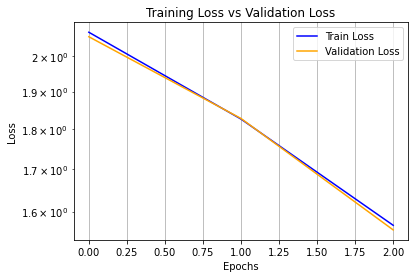

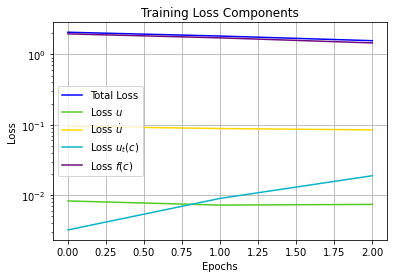

In [11]:
# Record training start time
time_train_model_1 = time.time()

# Train the model
Loss_u, Loss_udot, Loss_g, Loss_ut_c, Loss_e, Loss, Loss_val, best_loss = model_1.train(
    num_epochs=epochs_1, 
    learning_rate=1e-3, 
    bfgs=0
    )

# Record training end time
end_model_1 = time.time()
model_1_training_time = end_model_1 - time_train_model_1 

# Display total training time
print(f"Total training time for Model 1: {timedelta(seconds=model_1_training_time)}")

# Plot total training loss
plot_losses(train_loss=Loss, val_loss=Loss_val, title='Training Loss vs Validation Loss')

# Plot individual loss components
losses_1 = {
    'Total Loss': (Loss, 'blue'),                # Total training loss
    r'Loss $u$': (Loss_u, '#54ca22'),          # Loss for displacement prediction
    r'Loss $\dot{u}$': (Loss_udot, 'gold'),      # Loss for velocity prediction
    #r'Loss $g$': (Loss_g, '#fe9c16'),           # Loss for normalized restoring force prediction (don't use this)
    r'Loss $u_t(c)$': (Loss_ut_c, "#07b4c7"),  # Loss for velocity estimation from predicted displacements
    r'Loss $f(c)$': (Loss_e, "#71087f")       # Loss for normalized equation of motion
}

plot_losses(other_losses=losses_1, title='Training Loss Components')


Epoch: 0, Loss: 1.537e+00, Loss_val: 1.551e+00, Best_loss: 1.000e+02, Time: 4.27, Learning Rate: 1.000e-04
Epoch: 1, Loss: 1.511e+00, Loss_val: 1.505e+00, Best_loss: 1.000e+02, Time: 4.27, Learning Rate: 1.000e-04
Epoch: 2, Loss: 1.480e+00, Loss_val: 1.482e+00, Best_loss: 1.000e+02, Time: 4.27, Learning Rate: 1.000e-04
Loss: 1.480e+00, Loss_val: 1.482e+00, Best_loss: 1.000e+02
Loss: 1.480e+00, Loss_val: 1.482e+00, Best_loss: 1.000e+02
Loss: 1.480e+00, Loss_val: 1.482e+00, Best_loss: 1.000e+02
Loss: 1.480e+00, Loss_val: 1.482e+00, Best_loss: 1.000e+02
Loss: 1.480e+00, Loss_val: 1.482e+00, Best_loss: 1.000e+02
Loss: 1.480e+00, Loss_val: 1.482e+00, Best_loss: 1.000e+02
Loss: 1.480e+00, Loss_val: 1.482e+00, Best_loss: 1.000e+02
Loss: 1.480e+00, Loss_val: 1.482e+00, Best_loss: 1.000e+02
Loss: 1.480e+00, Loss_val: 1.482e+00, Best_loss: 1.000e+02
Loss: 1.480e+00, Loss_val: 1.482e+00, Best_loss: 1.000e+02
Loss: 1.480e+00, Loss_val: 1.482e+00, Best_loss: 1.000e+02
Loss: 1.480e+00, Loss_val: 1.4

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 1.479518
  Number of iterations: 1
  Number of functions evaluations: 29


Time taken for additional training of Model 1: 0:00:48.394844
Total training time for Model 1: 0:01:03.084887


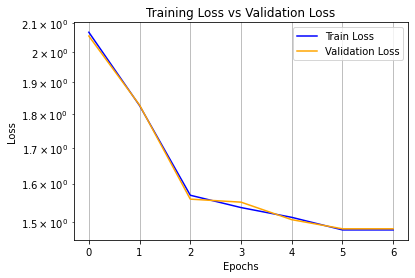

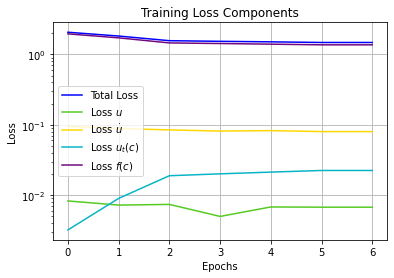

In [12]:
# Second training phase with different learning rate and BFGS optimization (the original code does not use a second training phase, but the paper does)
# Record training start time
new_time_train_model_1 = time.time()

# Train the model
new_Loss_u, new_Loss_udot, new_Loss_g, new_Loss_ut_c, new_Loss_e, new_Loss, new_Loss_val, best_loss = model_1.train(
    num_epochs=epochs_1, 
    learning_rate=1e-4, 
    bfgs=use_bfgs_1
    )

# Concatenate new losses with existing losses
Loss_u = np.concatenate([Loss_u, new_Loss_u])
Loss_udot = np.concatenate([Loss_udot, new_Loss_udot])
Loss_g = np.concatenate([Loss_g, new_Loss_g])
Loss_ut_c = np.concatenate([Loss_ut_c, new_Loss_ut_c])
Loss_e = np.concatenate([Loss_e, new_Loss_e])
Loss = np.concatenate([Loss, new_Loss])
Loss_val = np.concatenate([Loss_val, new_Loss_val])


# Save total loss
train_loss_1 = Loss
test_loss_1 = Loss_val
best_loss_1 = best_loss
all_losses_1 = {'Train_Loss': Loss, 'Loss_u': Loss_u, 'Loss_udot': Loss_udot,
                'Loss_g': Loss_g, 'Loss_ut_c': Loss_ut_c, 'Loss_e': Loss_e, 
                'Valid_Loss': Loss_val}

# Record training end time
end_model_1 = time.time()
new_model_1_training_time = end_model_1 - new_time_train_model_1
model_1_training_time = end_model_1 - time_train_model_1

# Display total training time
print(f"Time taken for additional training of Model 1: {timedelta(seconds=new_model_1_training_time)}")
print(f"Total training time for Model 1: {timedelta(seconds=model_1_training_time)}")

# Plot total training loss
plot_losses(train_loss=train_loss_1, val_loss=test_loss_1, title='Training Loss vs Validation Loss')

# Plot individual loss components
losses_1 = {
    'Total Loss': (Loss, 'blue'),                # Total training loss
    r'Loss $u$': (Loss_u, '#54ca22'),          # Loss for displacement prediction
    r'Loss $\dot{u}$': (Loss_udot, 'gold'),      # Loss for velocity prediction
    #r'Loss $g$': (Loss_g, '#fe9c16'),           # Loss for normalized restoring force prediction (don't use this)
    r'Loss $u_t(c)$': (Loss_ut_c, "#07b4c7"),  # Loss for velocity estimation from predicted displacements
    r'Loss $f(c)$': (Loss_e, "#71087f")       # Loss for normalized equation of motion
}

plot_losses(other_losses=losses_1, title='Training Loss Components')


---

1. **Loss from measured data (measurements)**

a) Displacement error $u$

$$
\mathcal{L}_u = \frac{1}{N} \sum_{i=1}^N \left( u_i - \hat{u}_i \right)^2
$$

b) Velocity error $\dot{u}$

$$
\mathcal{L}_{\dot{u}} = \frac{1}{N} \sum_{i=1}^N \left( \dot{u}_i - \hat{\dot{u}}_i \right)^2
$$

c) Normalized force term error $g$ and hysteretic variable $z$

$$
\mathcal{L}_g = \frac{1}{N} \sum_{i=1}^N \left( g_i - \hat{z}_i \right)^2 \quad \text{this one is not used}
$$

> Where:

* $\hat{u}_i , \hat{\dot{u}}_i , \hat{z}_i = \text{LSTM}_1(\text{a}_{g,i})$

---

2. **Loss from collocation points (physics-informed)**

a) Temporal consistency between estimation $\partial_t u$ and predicted velocity $\dot{u}$

$$
\mathcal{L}_{\text{col}, \dot{u}} = \frac{1}{N_c} \sum_{i=1}^{N_c} \left( \partial_t \hat{u}_i - \hat{\dot{u}}_i \right)^2
$$

b) Equation of motion error (negative seismic acceleration= acceleration + normalized force)

$$
\mathcal{L}_{\text{col}, \text{f}} = \frac{1}{N_c} \sum_{i=1}^{N_c} \left( -\text{a}_{g,i} - (\hat{u}_{tt,i} + \hat{g}_i) \right)^2
$$

> Where:

* $\hat{g}_i = \text{LSTM}_2(\hat{u}_i, \hat{\dot{u}}_i, \hat{z}_i)$

---

3. **Total loss**

$$
\mathcal{L}_{\text{total}} = \mathcal{L}_u + \mathcal{L}_{\dot{u}} + \mathcal{L}_{\text{col}, \dot{u}} + \mathcal{L}_{\text{col}, \text{f}}
$$


## Prediction

### Prediction on Known (Training) Data

In [13]:
# Inputs used during training
X_train_1 = ag_data_1[0:n_data_train_1]

# True reference values
y_train_ref_1 = u_data_1[0:n_data_train_1]
yt_train_ref_1 = ut_data_1[0:n_data_train_1]
ytt_train_ref_1 = utt_data_1[0:n_data_train_1]
lift_train_ref_1 = -X_train_1
g_train_ref_1 = -ytt_train_ref_1 + lift_train_ref_1

# Predict using trained model
eta, eta_t, eta_tt, eta_dot, g = model_1.predict(X_train_1, np.repeat(Phi_t0_1, len(X_train_1), axis=0))

lift = model_1.predict_c(X_train_1, np.repeat(Phi_t0_1, len(X_train_1), axis=0))

# Assign predictions
y_train_pred_1 = eta
yt_train_pred_1 = eta_t
ytt_train_pred_1 = eta_tt
ydot_train_pred_1 = eta_dot
g_train_pred_1 = -eta_tt + lift

# Print shapes of training prediction results
print(f"X_train_1         : {str(X_train_1.shape):<15} → External accelerations (input).")
print('-' * 100)
print(f"y_train_ref_1     : {str(y_train_ref_1.shape):<15} → Reference displacements.")
print(f"yt_train_ref_1    : {str(yt_train_ref_1.shape):<15} → Reference velocities.")
print(f"g_train_ref_1     : {str(g_train_ref_1.shape):<15} → Reference restoring forces.")
print('-' * 100)
print(f"y_train_pred_1    : {str(y_train_pred_1.shape):<15} → Predicted displacements.")
print(f"yt_train_pred_1   : {str(yt_train_pred_1.shape):<15} → Predicted ∂u/∂t.")
print(f"ydot_train_pred_1 : {str(ydot_train_pred_1.shape):<15} → Predicted velocities.")
print(f"g_train_pred_1    : {str(g_train_pred_1.shape):<15} → Predicted restoring forces.")

X_train_1         : (10, 1501, 1)   → External accelerations (input).
----------------------------------------------------------------------------------------------------
y_train_ref_1     : (10, 1501, 1)   → Reference displacements.
yt_train_ref_1    : (10, 1501, 1)   → Reference velocities.
g_train_ref_1     : (10, 1501, 1)   → Reference restoring forces.
----------------------------------------------------------------------------------------------------
y_train_pred_1    : (10, 1501, 1)   → Predicted displacements.
yt_train_pred_1   : (10, 1501, 1)   → Predicted ∂u/∂t.
ydot_train_pred_1 : (10, 1501, 1)   → Predicted velocities.
g_train_pred_1    : (10, 1501, 1)   → Predicted restoring forces.


### Prediction on Unseen (Test) Data

In [ ]:
# The following lines are used in the original code but not are correct according to the paper
# # Slice unseen prediction data
# X_pred_1 = ag_data_1[n_data_train_1:]
# # True reference values
# y_pred_ref_1 = u_data_1[n_data_train_1:]
# yt_pred_ref_1 = ut_data_1[n_data_train_1:]
# ytt_pred_ref_1 = utt_data_1[n_data_train_1:]

# Slice unseen prediction data
# Note: The original code uses the previous data slicing method, but according to the paper, we need to concatenate the following data.
X_pred_1 = np.concatenate([ag_data_1[n_data_train_1:], ag_pred_1], axis=0)  # Combine training and prediction data according to the paper
# True reference values
y_pred_ref_1 = np.concatenate([u_data_1[n_data_train_1:], u_pred_1], axis=0)  # Combine training and prediction data according to the paper
yt_pred_ref_1 = np.concatenate([ut_data_1[n_data_train_1:], ut_pred_1], axis=0)  # Combine training and prediction data according to the paper
ytt_pred_ref_1 = np.concatenate([utt_data_1[n_data_train_1:], utt_pred_1], axis=0)  # Combine training and prediction data according to the paper

lift_pred_ref_1 = -X_pred_1
g_pred_ref_1 = -ytt_pred_ref_1 + lift_pred_ref_1

# Predict using trained model
eta, eta_t, eta_tt, eta_dot, g = model_1.predict(X_pred_1, np.repeat(Phi_t0_1, len(X_pred_1), axis=0))
lift = model_1.predict_c(X_pred_1, np.repeat(Phi_t0_1, len(X_pred_1), axis=0))

# Assign predictions
y_pred_1 = eta
yt_pred_1 = eta_t
ydot_pred_1 = eta_dot
ytt_pred_1 = eta_tt
g_pred_1 = -eta_tt + lift

# Print shapes of unseen data predictions
print(f"X_pred_1        : {str(X_pred_1.shape):<15} → External accelerations (input unseen).")
print('-' * 100)
print(f"y_pred_ref_1    : {str(y_pred_ref_1.shape):<15} → Reference displacements (unseen).")
print(f"yt_pred_ref_1   : {str(yt_pred_ref_1.shape):<15} → Reference velocities (unseen).")
print(f"g_pred_ref_1    : {str(g_pred_ref_1.shape):<15} → Reference restoring forces (unseen).")
print('-' * 100)
print(f"y_pred_1        : {str(y_pred_1.shape):<15} → Predicted displacements (unseen).")
print(f"yt_pred_1       : {str(yt_pred_1.shape):<15} → Predicted ∂u/∂t (unseen).")
print(f"ydot_pred_1     : {str(ydot_pred_1.shape):<15} → Predicted velocities (unseen).")
print(f"g_pred_1        : {str(g_pred_1.shape):<15} → Predicted restoring forces (unseen).")


X_pred_1        : (75, 1501, 1)   → External accelerations (input unseen).
----------------------------------------------------------------------------------------------------
y_pred_ref_1    : (75, 1501, 1)   → Reference displacements (unseen).
yt_pred_ref_1   : (75, 1501, 1)   → Reference velocities (unseen).
g_pred_ref_1    : (75, 1501, 1)   → Reference restoring forces (unseen).
----------------------------------------------------------------------------------------------------
y_pred_1        : (75, 1501, 1)   → Predicted displacements (unseen).
yt_pred_1       : (75, 1501, 1)   → Predicted ∂u/∂t (unseen).
ydot_pred_1     : (75, 1501, 1)   → Predicted velocities (unseen).
g_pred_1        : (75, 1501, 1)   → Predicted restoring forces (unseen).


## Save Essential Results

In [15]:
# Record final time and compute elapsed time
model_1_end_time = time.time()
model_1_running_time = model_1_end_time - model_1_start_time
elapsed_time_model_1 = timedelta(seconds=model_1_running_time)
print(f"Total elapsed time for Model 1 -> {elapsed_time_model_1}")


Total elapsed time for Model 1 -> 0:01:11.553043


In [16]:
# Create a descriptive text explaining each saved variable
variable_descriptions_1 = '''
- X_train_1: Training inputs (external ground accelerations).
- y_train_ref_1: True displacement outputs used during training.
- yt_train_ref_1: True velocity outputs used during training.
- g_train_ref_1: True restoring force targets during training.

- y_train_pred_1: Predicted displacements on training data.
- yt_train_pred_1: Predicted ∂u/∂t values on training data.
- ydot_train_pred_1: Predicted velocity outputs on training data.
- g_train_pred_1: Predicted restoring force outputs on training data.

- X_pred_1: Input ground accelerations for prediction on unseen data.
- y_pred_ref_1: True displacements for unseen data.
- yt_pred_ref_1: True velocities for unseen data.
- g_pred_ref_1: True restoring forces for unseen data.

- y_pred_1: Predicted displacements for unseen data.
- yt_pred_1: Predicted ∂u/∂t for unseen data.
- ydot_pred_1: Predicted velocities for unseen data.
- g_pred_1: Predicted restoring forces for unseen data.

- train_loss_1: Total loss during training.
- all_losses_1: Dictionary containing individual loss components. (Loss: Total training loss, 
                                                                   Loss_u: Loss for displacement prediction, 
                                                                   Loss_udot: Loss for velocity prediction, 
                                                                   Loss_g: Loss for normalized restoring force prediction, 
                                                                   Loss_ut_c: Loss for velocity estimation from predicted displacements on collocation data, 
                                                                   Loss_e: Loss for normalized equation of motion on collocation data)
- Phi_t_1: Finite difference matrix used for time derivatives.
- model_1_running_time: Total execution time of the model (in seconds).
- epochs_1: Number of training epochs.
'''

In [17]:
# Save all relevant variables into a MATLAB file
scipy.io.savemat(
    result_file_path_1,
    {
        'X_train_1': X_train_1,
        'y_train_ref_1': y_train_ref_1,
        'yt_train_ref_1': yt_train_ref_1,
        'g_train_ref_1': g_train_ref_1,
        
        'y_train_pred_1': y_train_pred_1,
        'yt_train_pred_1': yt_train_pred_1,
        'ydot_train_pred_1': ydot_train_pred_1,
        'g_train_pred_1': g_train_pred_1,
        
        'X_pred_1': X_pred_1,
        'y_pred_ref_1': y_pred_ref_1,
        'yt_pred_ref_1': yt_pred_ref_1,
        'g_pred_ref_1': g_pred_ref_1,
        
        'y_pred_1': y_pred_1,
        'yt_pred_1': yt_pred_1,
        'ydot_pred_1': ydot_pred_1,
        'g_pred_1': g_pred_1,
        
        'train_loss_1': train_loss_1,
        'all_losses_1': all_losses_1,
        'Phi_t_1': Phi_t_1,
        'model_1_running_time': model_1_training_time,
        'epochs_1': epochs_1,
        'variable_descriptions_1': variable_descriptions_1
    }
)


## Results

In [18]:
from utils.evaluation_models import (
    calculate_errors_with_pdf,
    format_metrics_df,
    plot_error_pdfs,
    plot_regression_coeff_histogram,
    select_best_worst_series,
    plot_predictions
)

# Define feature names and indices to reuse in evaluation and plotting
feature_names_1 = ['Displacement', 'Velocity (calc)', 'Velocity', 'Normalized Restoring Force']
feature_units_1 = [         '[m]',           '[m/s]',    '[m/s]',                        '[N/kg]']
feature_indices_1 = [0, 1, 2, 3]

### Concatenate Prediction Outputs

In [19]:
# Concatenate predictions and reference outputs for joint evaluation
Y_pred_ref_1 = np.concatenate([y_pred_ref_1, yt_pred_ref_1, yt_pred_ref_1, g_pred_ref_1], axis=2)
Y_pred_1 = np.concatenate([y_pred_1, yt_pred_1, ydot_pred_1, g_pred_1], axis=2)

print(f"Y_pred_ref_1 : {Y_pred_ref_1.shape} → Reference outputs (Displacement, Velocity       , Velocity, Normalized Force)")
print(f"Y_pred_1     : {Y_pred_1.shape} → Predicted outputs (Displacement, Velocity (calc), Velocity, Normalized Force)")


Y_pred_ref_1 : (75, 1501, 4) → Reference outputs (Displacement, Velocity       , Velocity, Normalized Force)
Y_pred_1     : (75, 1501, 4) → Predicted outputs (Displacement, Velocity (calc), Velocity, Normalized Force)


### Evaluation Metrics

In [20]:
# Calculate Evaluation Metrics and PDFs for each feature
df_summary_1, errors_1, pdfs_1 = calculate_errors_with_pdf(
    Y_pred_ref_1, Y_pred_1,
    feature_names=feature_names_1
)

# Print unformatted metrics
print(df_summary_1)

                      Feature  MSE_mean   MSE_std   R2_mean    R2_std  \
0                Displacement  0.009219  0.008358 -0.636492  0.899845   
1             Velocity (calc)  0.057575  0.007751  0.403210  0.015056   
2                    Velocity  0.080706  0.010742  0.163512  0.007136   
3  Normalized Restoring Force  4.177508  0.429611  0.046678  0.011956   

   MAE_mean   MAE_std  Pearson_r_mean  Pearson_r_std  NormError_mean  \
0  0.073245  0.033677        0.575329       0.094730        0.122210   
1  0.198607  0.014644        0.756629       0.018512        0.000403   
2  0.232477  0.016806        0.770918       0.027461       -0.005192   
3  1.727345  0.106977        0.246294       0.046797       -0.000793   

   NormError_std  
0       0.238283  
1       0.005190  
2       0.005435  
3       0.004438  


In [21]:
# Format and display metrics
df_summary_formatted_1 = format_metrics_df(
    df_summary_1,
    metric_names=['R2', 'Pearson_r', 'NormError', 'MSE', 'MAE']
)
df_summary_formatted_1

,Feature,R2,Pearson_r,NormError,MSE,MAE
0,Displacement,-0.636492 ± 0.899845,0.575329 ± 0.094730,0.122210 ± 0.238283,0.009219 ± 0.008358,0.073245 ± 0.033677
1,Velocity (calc),0.403210 ± 0.015056,0.756629 ± 0.018512,0.000403 ± 0.005190,0.057575 ± 0.007751,0.198607 ± 0.014644
2,Velocity,0.163512 ± 0.007136,0.770918 ± 0.027461,-0.005192 ± 0.005435,0.080706 ± 0.010742,0.232477 ± 0.016806
3,Normalized Restoring Force,0.046678 ± 0.011956,0.246294 ± 0.046797,-0.000793 ± 0.004438,4.177508 ± 0.429611,1.727345 ± 0.106977


### Probability Density of Errors

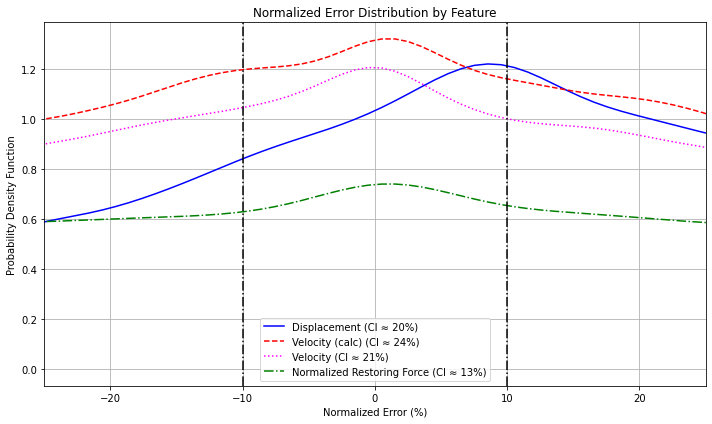

In [22]:
# Plot error probability density functions
plot_error_pdfs(pdfs_1, xlim_percent=(-25, 25))

### Regression Coefficient Histograms

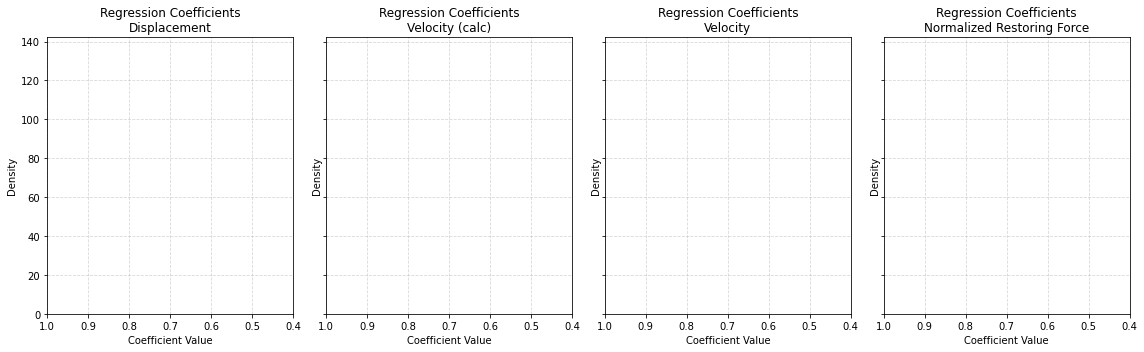

In [23]:
# Plot histograms of regression coefficients using predefined feature names and indices
plot_regression_coeff_histogram(
    Y_pred_ref_1,
    Y_pred_1,
    feature_names=feature_names_1,
    feature_indices=feature_indices_1,
    bins=20,
    xlim=(0.4, 1)
)

### Best and Worst Predictions

In [24]:
# Select best and worst prediction samples per feature
best_worst_1 = select_best_worst_series(
    errors_1, 
    'R2', 
    top_k=3,
    feature_names=feature_names_1
)
# Display the indices and metrics of best and worst predictions
print(best_worst_1)


{'Displacement': {'best': [(31, 0.320161080133912), (61, 0.30088377416888457), (64, 0.28231637604448967)], 'worst': [(22, -2.9004540090470963), (20, -3.1355093350661134), (63, -3.1543069424649746)]}, 'Velocity (calc)': {'best': [(23, 0.439254722614028), (21, 0.4380694201733537), (8, 0.43741526460534086)], 'worst': [(13, 0.3779803724817544), (20, 0.37043690567175047), (53, 0.3660704458517807)]}, 'Velocity': {'best': [(23, 0.18436307352267256), (31, 0.18059792982268053), (8, 0.1785263369901352)], 'worst': [(35, 0.1494394422133155), (20, 0.1493163541253335), (53, 0.144525233793118)]}, 'Normalized Restoring Force': {'best': [(73, 0.07492271052327182), (24, 0.07137258537409796), (38, 0.06715701223120363)], 'worst': [(23, 0.024772585097567523), (27, 0.02381043694475138), (50, 0.020190117766727966)]}}


In [25]:
# Create structured dictionary for easier loop-based plotting
dict_best_worst_1 = {
    feature: {
        'best': [idx for idx, _ in best_worst_1[feature]['best']],
        'worst': [idx for idx, _ in best_worst_1[feature]['worst']]
    }
    for feature in best_worst_1
}

print(dict_best_worst_1)

{'Displacement': {'best': [31, 61, 64], 'worst': [22, 20, 63]}, 'Velocity (calc)': {'best': [23, 21, 8], 'worst': [13, 20, 53]}, 'Velocity': {'best': [23, 31, 8], 'worst': [35, 20, 53]}, 'Normalized Restoring Force': {'best': [73, 24, 38], 'worst': [23, 27, 50]}}


### Time-Series Plots: Best Predictions

############################## Best Prediction Displacement ##################################################


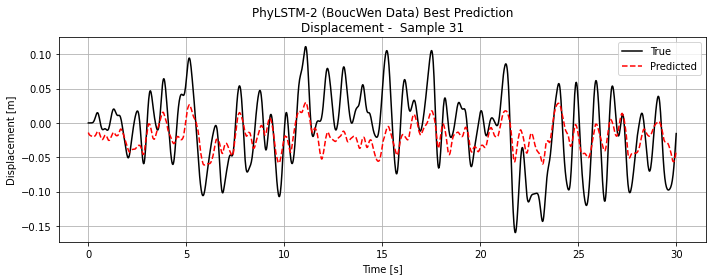

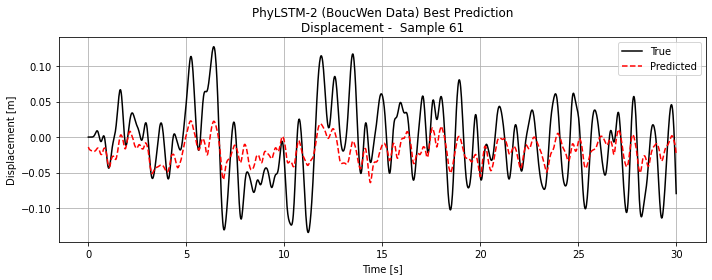

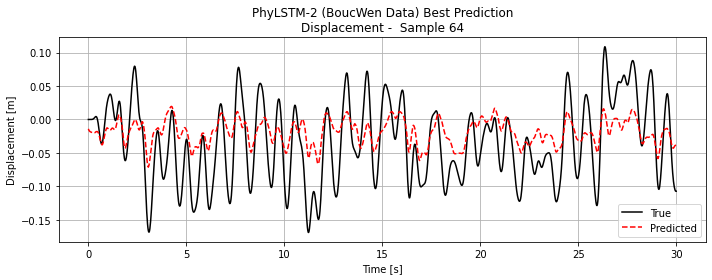

############################## Best Prediction Velocity (calc) ##################################################


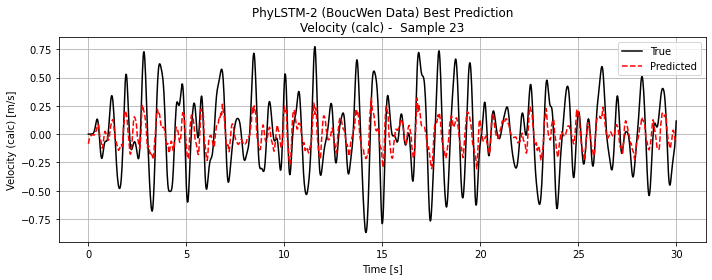

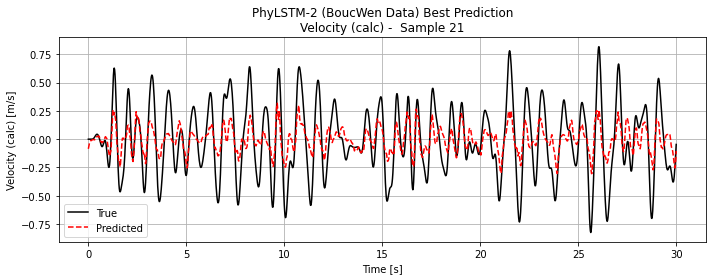

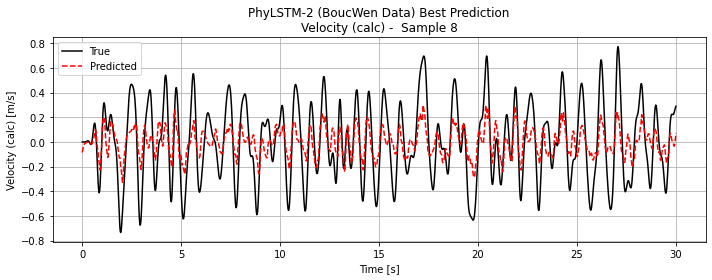

############################## Best Prediction Velocity ##################################################


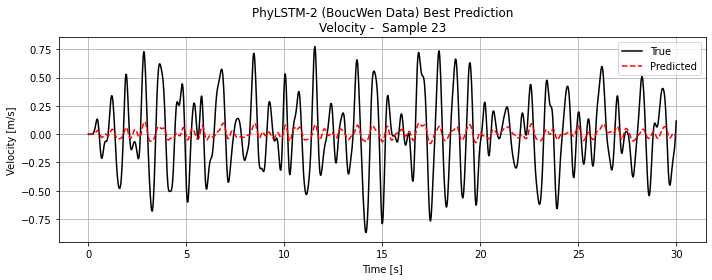

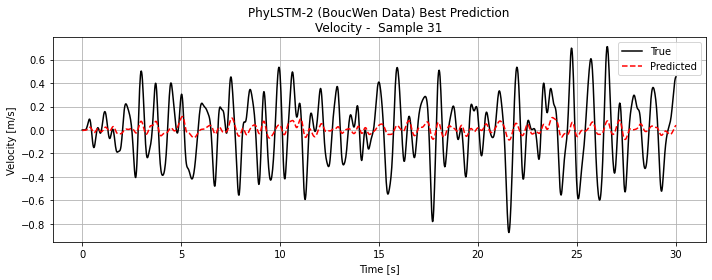

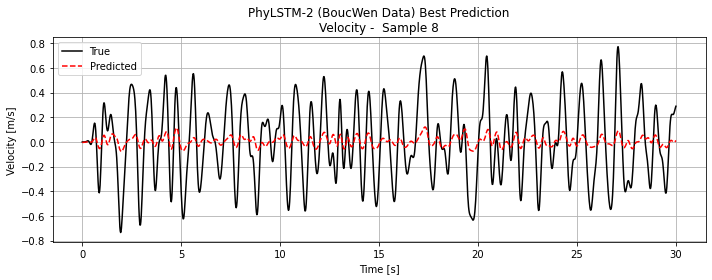

############################## Best Prediction Normalized Restoring Force ##################################################


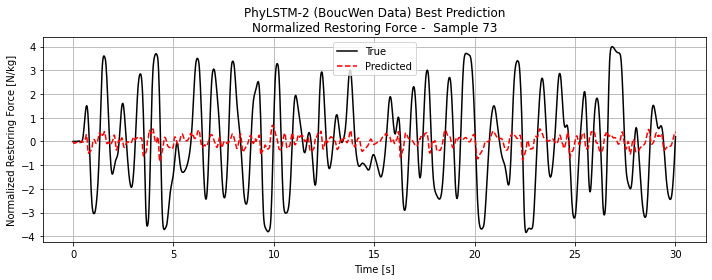

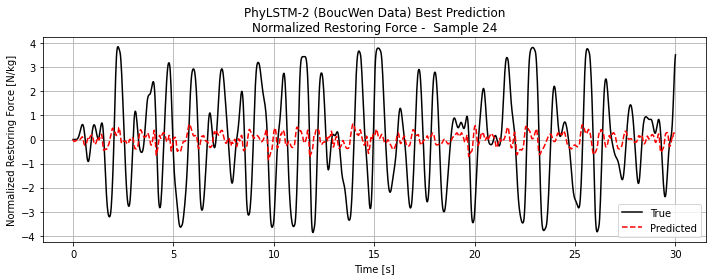

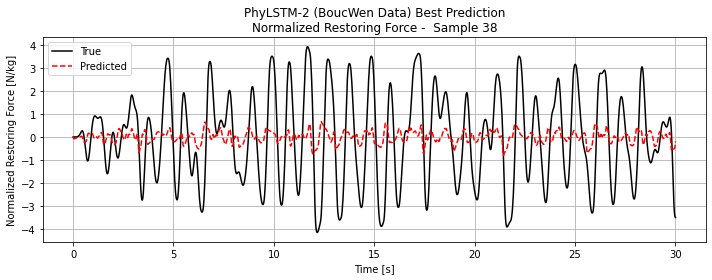

In [26]:
for i, feature in enumerate(feature_names_1):
    print('#' * 30 + f' Best Prediction {feature} ' + '#' * 50)
    plot_predictions(
        Y_pred_ref_1, Y_pred_1,
        title=f"{model_type_1} ({data_base_1}) Best Prediction\n{feature} - ",
        dt=dt_1,
        sample_indices=dict_best_worst_1[feature]['best'],
        feature_idx=i,
        feature_label=feature+' '+feature_units_1[i],
        show_original=False
    )

### Time-Series Plots: Worst Predictions

############################## Worst Prediction Displacement ##################################################


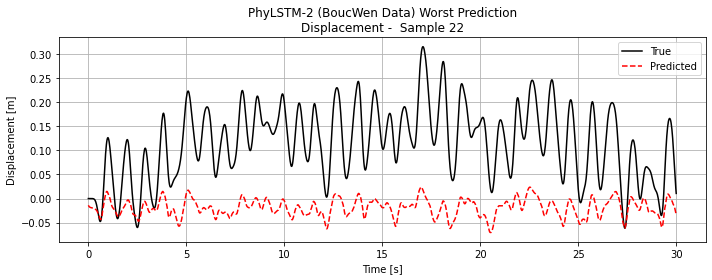

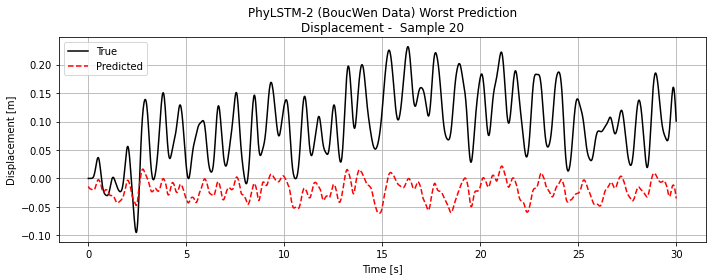

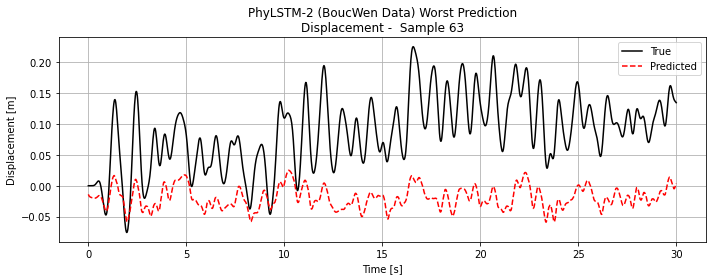

############################## Worst Prediction Velocity (calc) ##################################################


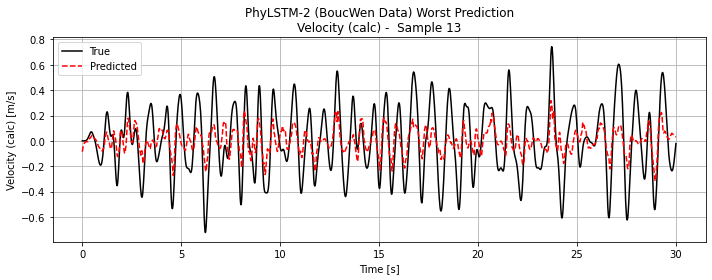

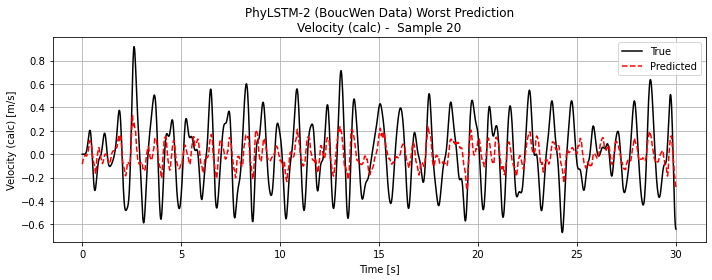

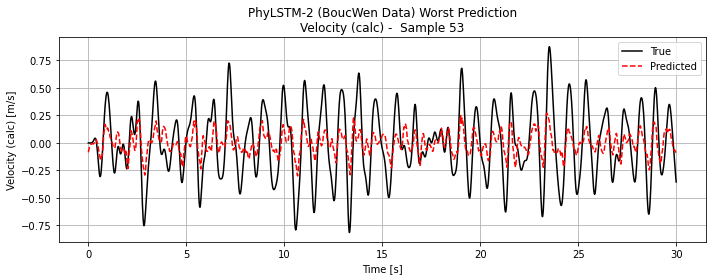

############################## Worst Prediction Velocity ##################################################


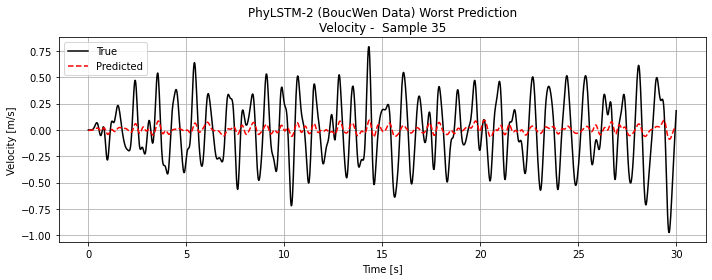

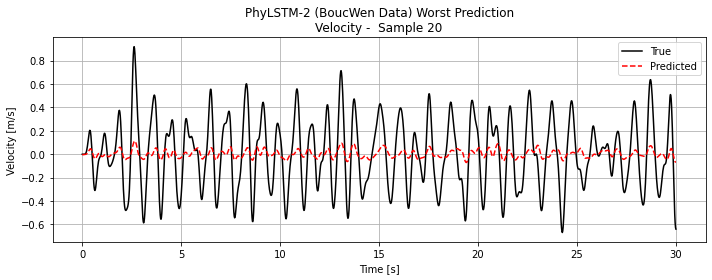

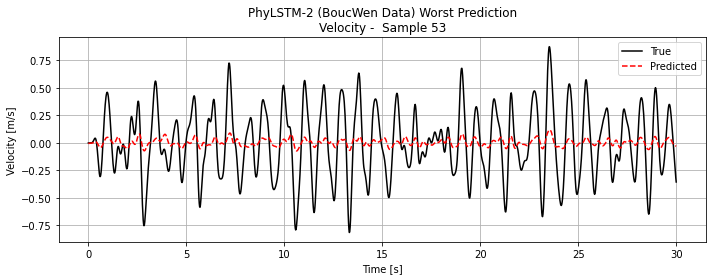

############################## Worst Prediction Normalized Restoring Force ##################################################


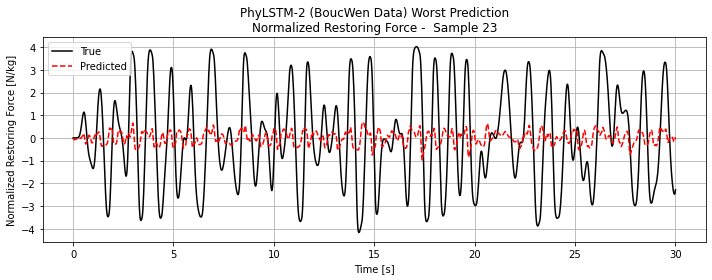

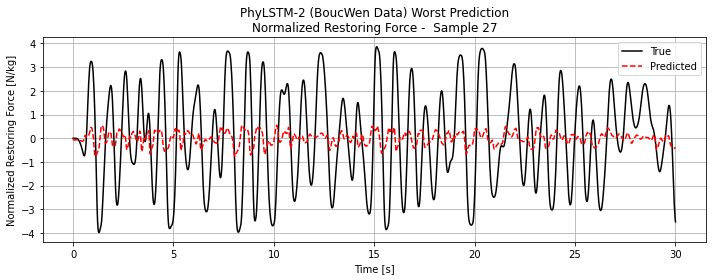

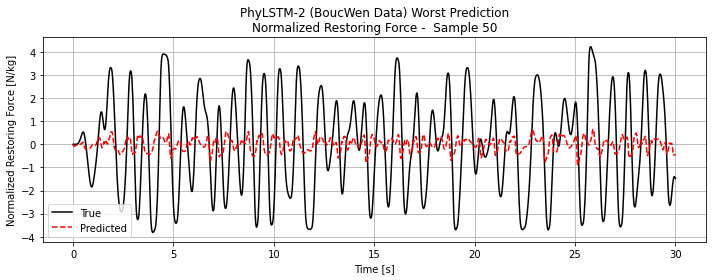

In [27]:
for i, feature in enumerate(feature_names_1):
    print('#' * 30 + f' Worst Prediction {feature} ' + '#' * 50)
    plot_predictions(
        Y_pred_ref_1, Y_pred_1,
        title=f"{model_type_1} ({data_base_1}) Worst Prediction\n{feature} - ",
        dt=dt_1,
        sample_indices=dict_best_worst_1[feature]['worst'],
        feature_idx=i,
        feature_label=feature+' '+feature_units_1[i],
        show_original=False
    )


### Save Evaluation Summary

In [28]:
# Record total end time (global, not just training)
generate_end_time = time.time()
total_runtime_global = timedelta(seconds=generate_end_time - general_start_time)
total_runtime_model_1 = generate_end_time - model_1_start_time

print(f"Total elapsed time from script start       : {total_runtime_global}")
print(f"Total elapsed time for Model 1 (from start): {timedelta(seconds=total_runtime_model_1)}")

# Define README content
readme_content_1 = ('''
    This NPZ file contains the following keys:
    - errors: Full list of error values with shape (n_samples, n_features, n_metrics, 2).\n
    - metrics: Dictionary of metric values for each evaluation metric.\n
    - best_worst_indices: Dictionary with best and worst prediction indices per feature.\n
    - description: Metadata describing the content of this file.
    '''
)

# Prepare data for saving
errors_array_1 = errors_1  # array of errors
metrics_dict_1 = df_summary_formatted_1.to_dict(orient="list")  # dictionary of metrics
best_worst_dict_1 = dict_best_worst_1  # dictionary of best and worst indices
description_str_1 = readme_content_1  # description of the saved data

# Save to .npz (using pickle for non-array objects like dicts)
output_path_1 = os.path.join(results_path_1, "model_1_all_evaluation_results.npz")
np.savez_compressed(
    output_path_1,
    errors=errors_array_1,
    metrics=np.array([metrics_dict_1], dtype=object),
    best_worst=np.array([best_worst_dict_1], dtype=object),
    description=np.array(description_str_1)
)

print(f"Saved .npz file to: {output_path_1}")


Total elapsed time from script start       : 0:01:19.179454
Total elapsed time for Model 1 (from start): 0:01:17.276535
Saved .npz file to: /home/fermandoislab/Desktop/Proyecto PINNs/Dev-PINNs-for-Nonlinear-Dynamic-Structural-Response/results/results_phylstm/phylstm2_boucwen/model_1_all_evaluation_results.npz


In [29]:
delete_all_other_variables(keep_vars)

Memory cleaned. Objects collected: 69742


69742

---
# Model 2: PhyLSTM-3 on Bouc-Wen SDOF
---

## Model Definition

In [ ]:
# Type of PhyCNN model ('PhyLSTM-2' or 'PhyLSTM-3')
model_type_2 = 'PhyLSTM-3'

# Dataset identifier
data_base_2 = 'BoucWen Data'

# Number of training epochs
epochs_2 = 3#5000

# Use BFGS optimization for training after initial training
use_bfgs_2 = 1 # Use BFGS optimization for training

# Batch size for training
n_data_train_2 = 10 #(The original code uses all the data, but the paper says only 10 samples were used.)

# Number of collocation samples
n_data_collocation_2 = 50 # The original code uses 53 samples, but the paper says only 50 samples were used.

# Step size for downsampling the input data
downsample_step_2 = 1 #int(0.02/0.005)  # the original code uses 0.02/0.005, which is 4, but the paper does not specify this value.

# Record the start time for Model 2’s training
model_2_start_time = time.time()

# Define path to store results
results_path_2 = project_root + '/results/results_phylstm/phylstm3_boucwen'
os.makedirs(results_path_2, exist_ok=True)

# Define path to save the best model for Model 2
model_path_2 = results_path_2 + '/my_best_model_phylstm3_boucwen.h5'

# Define path to save the results for Model 2
result_file_path_2 = results_path_2 + '/results_PhyLSTM3_boucwenSDOF.mat'

## Load Data: Bouc-Wen Data

In [31]:
# Load MATLAB data file
mat_2 = scipy.io.loadmat(project_root + '/data/raw/data_boucwen.mat')

# Optional: inspect available variables
print(mat_2.keys())

dict_keys(['__header__', '__version__', '__globals__', 'Ind_P', 'Ind_TV', 'input_pred_tf', 'input_tf', 'target_X_tf', 'target_Xd_tf', 'target_Xdd_tf', 'target_pred_X_tf', 'target_pred_Xd_tf', 'target_pred_Xdd_tf', 'time', 'trainInd', 'valInd'])


In [32]:
# Print available variable shapes
print('-' * 100)
print(f"input_tf          : {str(mat_2['input_tf'].shape):<15} → Inputs for training/validation (e.g., ground accelerations).")
print(f"target_X_tf       : {str(mat_2['target_X_tf'].shape):<15} → Displacement targets for training/validation.")
print(f"target_Xd_tf      : {str(mat_2['target_Xd_tf'].shape):<15} → Velocity targets for training/validation.")
print(f"target_Xdd_tf     : {str(mat_2['target_Xdd_tf'].shape):<15} → Acceleration targets for training/validation.")
print(f"input_pred_tf     : {str(mat_2['input_pred_tf'].shape):<15} → Inputs for prediction (unseen ground accelerations).")
print(f"target_pred_X_tf  : {str(mat_2['target_pred_X_tf'].shape):<15} → True displacements for prediction.")
print(f"target_pred_Xd_tf : {str(mat_2['target_pred_Xd_tf'].shape):<15} → True velocities for prediction.")
print(f"target_pred_Xdd_tf: {str(mat_2['target_pred_Xdd_tf'].shape):<15} → True accelerations for prediction.")
print(f"time              : {str(mat_2['time'].shape):<15} → Time vector for inputs/outputs.(in seconds)")
print(f"Ind_TV            : {str(mat_2['Ind_TV'].shape):<15} → Indices for Train+Val set.")
print(f"Ind_P             : {str(mat_2['Ind_P'].shape):<15} → Indices for Prediction set. (Test set)")
print(f"trainInd          : {str(mat_2['trainInd'].shape):<15} → Indices for training set.")
print(f"valInd            : {str(mat_2['valInd'].shape):<15} → Indices for validation set.")
print('-' * 100)

----------------------------------------------------------------------------------------------------
input_tf          : (85, 1501)      → Inputs for training/validation (e.g., ground accelerations).
target_X_tf       : (85, 1501)      → Displacement targets for training/validation.
target_Xd_tf      : (85, 1501)      → Velocity targets for training/validation.
target_Xdd_tf     : (85, 1501)      → Acceleration targets for training/validation.
input_pred_tf     : (15, 1501)      → Inputs for prediction (unseen ground accelerations).
target_pred_X_tf  : (15, 1501)      → True displacements for prediction.
target_pred_Xd_tf : (15, 1501)      → True velocities for prediction.
target_pred_Xdd_tf: (15, 1501)      → True accelerations for prediction.
time              : (1, 1501)       → Time vector for inputs/outputs.(in seconds)
Ind_TV            : (1, 85)         → Indices for Train+Val set.
Ind_P             : (1, 15)         → Indices for Prediction set. (Test set)
trainInd          : (

Define loaded data with known variable names

In [33]:
# Extract and reshape data
ag_data_2 = mat_2['input_tf'][: ,::downsample_step_2]       # external acceleration
u_data_2 = mat_2['target_X_tf'][: ,::downsample_step_2]     # floor displacement 
ut_data_2 = mat_2['target_Xd_tf'][: ,::downsample_step_2]   # floor velocity
utt_data_2 = mat_2['target_Xdd_tf'][: ,::downsample_step_2] # floor acceleration

# Reshape to [samples, timesteps, 1]
ag_data_2 = ag_data_2.reshape([ag_data_2.shape[0], ag_data_2.shape[1], 1])
u_data_2 = u_data_2.reshape([u_data_2.shape[0], u_data_2.shape[1], 1])
ut_data_2 = ut_data_2.reshape([ut_data_2.shape[0], ut_data_2.shape[1], 1])
utt_data_2 = utt_data_2.reshape([utt_data_2.shape[0], utt_data_2.shape[1], 1])

# Time vector
t = mat_2['time']
dt = t[0, 1] - t[0, 0]
t_2 = t[:,::downsample_step_2]
dt_2 = t_2[0, 1] - t_2[0, 0]

# Print shape information
print(f"t           : {t.shape} → Original time vector.")
print(f"dt          : {dt} s    → Original time step.")
print('-' * 100)
print(f"t_2         : {t_2.shape} → Downsampled time vector.")
print(f"dt_2        : {dt_2} s   → Downsampled time step.")
print(f"ag_data_2   : {ag_data_2.shape} → Ground accelerations (inputs).")
print(f"u_data_2    : {u_data_2.shape} → Floor displacements (outputs).")
print(f"ut_data_2   : {ut_data_2.shape} → Floor velocities (outputs).")
print(f"utt_data_2  : {utt_data_2.shape} → Floor accelerations (outputs).")
print('-' * 100)

t           : (1, 1501) → Original time vector.
dt          : 0.02 s    → Original time step.
----------------------------------------------------------------------------------------------------
t_2         : (1, 376) → Downsampled time vector.
dt_2        : 0.08 s   → Downsampled time step.
ag_data_2   : (85, 376, 1) → Ground accelerations (inputs).
u_data_2    : (85, 376, 1) → Floor displacements (outputs).
ut_data_2   : (85, 376, 1) → Floor velocities (outputs).
utt_data_2  : (85, 376, 1) → Floor accelerations (outputs).
----------------------------------------------------------------------------------------------------


In [34]:
# Extract and reshape data
ag_pred_2 = mat_2['input_pred_tf'][: ,::downsample_step_2]       # external acceleration
u_pred_2 = mat_2['target_pred_X_tf'][: ,::downsample_step_2]     # floor displacement 
ut_pred_2 = mat_2['target_pred_Xd_tf'][: ,::downsample_step_2]   # floor velocity
utt_pred_2 = mat_2['target_pred_Xdd_tf'][: ,::downsample_step_2] # floor acceleration

# Reshape to [samples, timesteps, 1]
ag_pred_2 = ag_pred_2.reshape([ag_pred_2.shape[0], ag_pred_2.shape[1], 1])
u_pred_2 = u_pred_2.reshape([u_pred_2.shape[0], u_pred_2.shape[1], 1])
ut_pred_2 = ut_pred_2.reshape([ut_pred_2.shape[0], ut_pred_2.shape[1], 1])
utt_pred_2 = utt_pred_2.reshape([utt_pred_2.shape[0], utt_pred_2.shape[1], 1])

# Print shape information
print(f"ag_pred_2   : {ag_pred_2.shape} → Ground accelerations for prediction on unseen data (inputs).")
print(f"u_pred_2    : {u_pred_2.shape} → Floor displacements for prediction on unseen data (outputs).")
print(f"ut_pred_2   : {ut_pred_2.shape} → Floor velocities for prediction on unseen data (outputs).")
print(f"utt_pred_2  : {utt_pred_2.shape} → Floor accelerations for prediction on unseen data (outputs).")
print('-' * 100)

ag_pred_2   : (15, 376, 1) → Ground accelerations for prediction on unseen data (inputs).
u_pred_2    : (15, 376, 1) → Floor displacements for prediction on unseen data (outputs).
ut_pred_2   : (15, 376, 1) → Floor velocities for prediction on unseen data (outputs).
utt_pred_2  : (15, 376, 1) → Floor accelerations for prediction on unseen data (outputs).
----------------------------------------------------------------------------------------------------


**Finite Difference Matrix for Time Derivatives**

To compute the time derivative of the displacement vector **u**, we define a finite difference matrix **$\Phi$** such that:

$$
    \frac{\partial u}{\partial t} = \Phi \, u
$$

Here, **$\Phi$** is a banded matrix that applies centered finite differences to approximate the time derivative. For a sequence of length $N$, the structure of **$\Phi$** is:

$$
\Phi =
\begin{pmatrix}
  -\tfrac{3}{2} & 2 & -\tfrac{1}{2} & 0 & \cdots & 0 \\
  0 & -\tfrac{1}{2} & 0 & \tfrac{1}{2} & \cdots & 0 \\
  0 & 0 & -\tfrac{1}{2} & 0 & \ddots & 0 \\
  \vdots & & & \ddots & \ddots & \tfrac{1}{2} \\
  0 & \cdots & 0 & -\tfrac{1}{2} & 0 & \tfrac{1}{2} \\
  0 & \cdots & 0 & -\tfrac{1}{2} & 2 & -\tfrac{3}{2}  
\end{pmatrix}
$$

* **First row**: a one-sided finite difference of order 2 to handle the boundary:
  $\Phi_{1,:} = [-\tfrac{3}{2}, \; 2, \; -\tfrac{1}{2}, \; 0, \; \dots]$
* **Interior rows** (from 2 to $N-1$): centered difference:
  $\Phi_{i,:} = [\dots, \; -\tfrac{1}{2}, \; 0, \; \tfrac{1}{2}, \; \dots]$
* **Last row**: one-sided of order 2 at the end:
  $\Phi_{N,:} = [\dots, \; 0, \; -\tfrac{1}{2}, \; 2, \; -\tfrac{3}{2}]$

This construction ensures second-order accuracy in the approximation of $\partial u / \partial t$.



In [35]:
# Construct finite difference matrix Phi for ∂/∂t
n_2 = u_data_2.shape[1]
phi1 = np.concatenate([np.array([-3 / 2, 2, -1 / 2]), np.zeros([n_2 - 3])])
temp1 = np.concatenate([-0.5 * np.identity(n_2 - 2), np.zeros([n_2 - 2, 2])], axis=1)
temp2 = np.concatenate([np.zeros([n_2 - 2, 2]), 0.5 * np.identity(n_2 - 2)], axis=1)
phi2 = temp1 + temp2
phi3 = np.concatenate([np.zeros([n_2 - 3]), np.array([0.5, -2, 1.5])])

Phi_t0_2 = (1 / dt_2) * np.concatenate(
    [np.reshape(phi1, [1, phi1.shape[0]]), phi2, np.reshape(phi3, [1, phi3.shape[0]])], axis=0
)

Phi_t0_2 = np.reshape(Phi_t0_2, [1, n_2, n_2])

print(f"Phi_t0_2 : {Phi_t0_2.shape} → Finite difference matrix for computing velocities/accelerations.")


Phi_t0_2 : (1, 376, 376) → Finite difference matrix for computing velocities/accelerations.


**Training Data Selection**

In [ ]:
# Subset of samples for training
ag_star_2 = ag_data_2[0:n_data_train_2]
eta_star_2 = u_data_2[0:n_data_train_2]
eta_t_star_2 = ut_data_2[0:n_data_train_2]
eta_tt_star_2 = utt_data_2[0:n_data_train_2]

# Normalized force terms and right-hand side of the physical equation
g_star_2 = -eta_tt_star_2 - ag_star_2

# Subset of samples for collocation
ag_c_star_2 = np.concatenate([ag_star_2,ag_data_2[n_data_train_2:n_data_train_2+n_data_collocation_2]]) 
lift_c_star_2 = -ag_c_star_2
eta_c_star_2 = np.concatenate([eta_star_2, u_data_2[n_data_train_2:n_data_train_2+n_data_collocation_2]]) 
eta_t_c_star_2 = np.concatenate([eta_t_star_2, ut_data_2[n_data_train_2:n_data_train_2+n_data_collocation_2]]) 
eta_tt_c_star_2 = np.concatenate([eta_tt_star_2, utt_data_2[n_data_train_2:n_data_train_2+n_data_collocation_2]]) 

# Original code uses the following lines, but this is not correct according to the paper.
# ag_c_star_2 = np.concatenate([ag_data_2, ag_pred_2[0:n_data_collocation_2]])
# lift_c_star_2 = -ag_c_star_2
# eta_c_star_2 = np.concatenate([u_data_2, u_pred_2[0:n_data_collocation_2]])
# eta_t_c_star_2 = np.concatenate([ut_data_2, ut_pred_2[0:n_data_collocation_2]])
# eta_tt_c_star_2 =  np.concatenate([utt_data_2, utt_pred_2[0:n_data_collocation_2]])

# Assign final training variables
ag_train_2 = ag_star_2
eta_train_2 = eta_star_2
eta_t_train_2 = eta_t_star_2
eta_tt_train_2 = eta_tt_star_2
g_train_2 = g_star_2

ag_c_train_2 = ag_c_star_2
lift_train_2 = lift_c_star_2

# Repeat finite difference matrix for each collocation sample
Phi_t_2 = np.repeat(Phi_t0_2, ag_c_star_2.shape[0], axis=0)
print(f"Phi_t_2 : {Phi_t_2.shape} → Finite difference matrix for computing velocities/accelerations for collocation samples.")
print('-' * 100)

# Print training data shapes
print(f"ag_train_2     : {str(ag_train_2.shape):<15} → Ground acceleration inputs for training.")
print(f"eta_train_2    : {str(eta_train_2.shape):<15} → Displacement outputs for training.")
print(f"eta_t_train_2  : {str(eta_t_train_2.shape):<15} → Velocity outputs for training.")
print(f"eta_tt_train_2 : {str(eta_tt_train_2.shape):<15} → Acceleration variables used for training.")
print(f"g_train_2      : {str(g_train_2.shape):<15} → Restoring force (normalized) outputs for training.")
print(f"ag_c_train_2   : {str(ag_c_train_2.shape):<15} → Ground acceleration collocation data for training.")
print(f"lift_train_2   : {str(lift_train_2.shape):<15} → External acceleration inverted collocation data used for training.")


Phi_t_2 : (100, 376, 376) → Finite difference matrix for computing velocities/accelerations for collocation samples.
----------------------------------------------------------------------------------------------------
ag_train_2     : (10, 376, 1)    → Ground acceleration inputs for training.
eta_train_2    : (10, 376, 1)    → Displacement outputs for training.
eta_t_train_2  : (10, 376, 1)    → Velocity outputs for training.
eta_tt_train_2 : (10, 376, 1)    → Acceleration variables used for training.
g_train_2      : (10, 376, 1)    → Restoring force (normalized) outputs for training.
ag_c_train_2   : (100, 376, 1)   → Ground acceleration collocation data for training.
lift_train_2   : (100, 376, 1)   → External acceleration inverted collocation data used for training.


## Training for Model 2

### Model Architecture Setup

In [37]:
from models.phylstm.model_architecture_phylstm import DeepPhyLSTM3, plot_losses

# TensorFlow configuration GPU settings
config_2 = tf.ConfigProto()
config_2.gpu_options.allow_growth = True
# config_2.gpu_options.per_process_gpu_memory_fraction = 0.4
session_2 = tf.Session(config=config_2)
# tf.Session(config=tf.ConfigProto(log_device_placement=True))

# Build the model using the training data
model_2 = DeepPhyLSTM3(eta_train_2, eta_t_train_2, g_train_2, ag_train_2, ag_c_train_2, lift_train_2, Phi_t_2)


Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:01:00.0, compute capability: 8.6



### Training Execution

Epoch: 0, Loss: 2.291e+00, Loss_val: 2.284e+00, Best_loss: 1.000e+02, Time: 3.11, Learning Rate: 1.000e-03
Epoch: 1, Loss: 2.256e+00, Loss_val: 2.247e+00, Best_loss: 1.000e+02, Time: 0.83, Learning Rate: 1.000e-03
Epoch: 2, Loss: 2.209e+00, Loss_val: 2.228e+00, Best_loss: 1.000e+02, Time: 0.83, Learning Rate: 1.000e-03
Total training time for Model 2: 0:00:04.767869


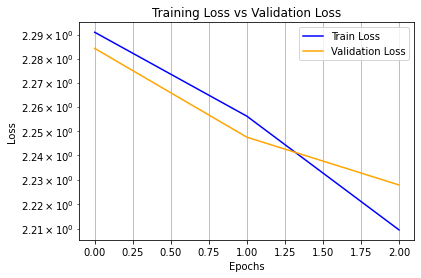

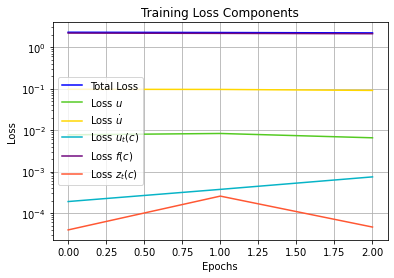

In [38]:
# Record training start time
time_train_model_2 = time.time()

# Train the model
Loss_u, Loss_udot, Loss_g, Loss_ut_c, Loss_gt_c, Loss_e, Loss, Loss_val, best_loss = model_2.train(
    num_epochs=epochs_2, 
    learning_rate=1e-3, 
    bfgs=0
    )

# Record training end time
end_model_2 = time.time()
model_2_training_time = end_model_2 - time_train_model_2

# Display total training time
print(f"Total training time for Model 2: {timedelta(seconds=model_2_training_time)}")

# Plot total training loss
plot_losses(train_loss=Loss, val_loss=Loss_val, title='Training Loss vs Validation Loss')

# Plot individual loss components
losses_2 = {
    'Total Loss': (Loss, 'blue'),                # Total training loss
    r'Loss $u$': (Loss_u, '#54ca22'),          # Loss for displacement prediction
    r'Loss $\dot{u}$': (Loss_udot, 'gold'),      # Loss for velocity prediction
    #r'Loss $g$': (Loss_g, '#fe9c16'),           # Loss for normalized restoring force prediction (don't use this)
    r'Loss $u_t(c)$': (Loss_ut_c, "#07b4c7"),  # Loss for velocity estimation from predicted displacements
    r'Loss $f(c)$': (Loss_e, "#71087f"),       # Loss for normalized equation of motion
    r'Loss $z_t(c)$': (Loss_gt_c, "#ff5733")   # Loss for rate of change of the hysteretic parameter
}

plot_losses(other_losses=losses_2, title='Training Loss Components')

Epoch: 0, Loss: 2.211e+00, Loss_val: 2.199e+00, Best_loss: 1.000e+02, Time: 0.82, Learning Rate: 1.000e-04
Epoch: 1, Loss: 2.203e+00, Loss_val: 2.204e+00, Best_loss: 1.000e+02, Time: 0.84, Learning Rate: 1.000e-04
Epoch: 2, Loss: 2.197e+00, Loss_val: 2.200e+00, Best_loss: 1.000e+02, Time: 0.83, Learning Rate: 1.000e-04
Loss: 2.197e+00, Loss_val: 2.200e+00, Best_loss: 1.000e+02
Loss: 2.197e+00, Loss_val: 2.200e+00, Best_loss: 1.000e+02
Loss: 2.197e+00, Loss_val: 2.200e+00, Best_loss: 1.000e+02
Loss: 2.197e+00, Loss_val: 2.200e+00, Best_loss: 1.000e+02
Loss: 2.197e+00, Loss_val: 2.200e+00, Best_loss: 1.000e+02
Loss: 2.197e+00, Loss_val: 2.200e+00, Best_loss: 1.000e+02
Loss: 2.197e+00, Loss_val: 2.200e+00, Best_loss: 1.000e+02
Loss: 2.197e+00, Loss_val: 2.200e+00, Best_loss: 1.000e+02
Loss: 2.197e+00, Loss_val: 2.200e+00, Best_loss: 1.000e+02
Loss: 2.197e+00, Loss_val: 2.200e+00, Best_loss: 1.000e+02
Loss: 2.197e+00, Loss_val: 2.200e+00, Best_loss: 1.000e+02
Loss: 2.197e+00, Loss_val: 2.2

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 2.196612
  Number of iterations: 1
  Number of functions evaluations: 26


Time taken for additional training of Model 2: 0:00:12.429506
Total training time for Model 2: 0:00:17.702393


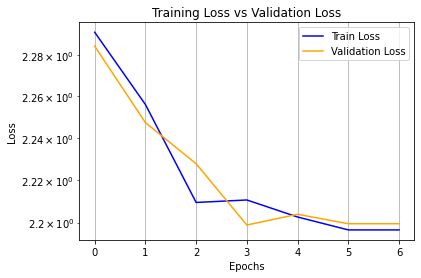

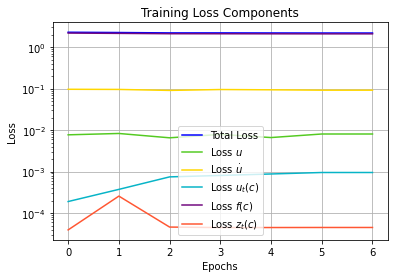

In [39]:
# Second training phase with different learning rate and BFGS optimization (the original code does not use a second training phase, but the paper does)
# Record training start time
new_time_train_model_2 = time.time()

# Train the model
new_Loss_u, new_Loss_udot, new_Loss_g, new_Loss_ut_c, new_Loss_gt_c, new_Loss_e, new_Loss, new_Loss_val, best_loss = model_2.train(
    num_epochs=epochs_2, 
    learning_rate=1e-4, 
    bfgs=use_bfgs_2
    )


# Concatenate new losses with existing losses
Loss_u = np.concatenate([Loss_u, new_Loss_u])
Loss_udot = np.concatenate([Loss_udot, new_Loss_udot])
Loss_g = np.concatenate([Loss_g, new_Loss_g])
Loss_ut_c = np.concatenate([Loss_ut_c, new_Loss_ut_c])
Loss_gt_c = np.concatenate([Loss_gt_c, new_Loss_gt_c])
Loss_e = np.concatenate([Loss_e, new_Loss_e])
Loss = np.concatenate([Loss, new_Loss])
Loss_val = np.concatenate([Loss_val, new_Loss_val])


# Save total loss
train_loss_2 = Loss
test_loss_2 = Loss_val
best_loss_2 = best_loss
all_losses_2 = {'Train_Loss': Loss, 'Loss_u': Loss_u, 'Loss_udot': Loss_udot,
                'Loss_g': Loss_g, 'Loss_ut_c': Loss_ut_c, 'Loss_e': Loss_e, 
                'Loss_gt_c': Loss_gt_c,
                'Valid_Loss': Loss_val}


# Record training end time
end_model_2 = time.time()
new_model_2_training_time = end_model_2 - new_time_train_model_2
model_2_training_time = end_model_2 - time_train_model_2

# Display total training time
print(f"Time taken for additional training of Model 2: {timedelta(seconds=new_model_2_training_time)}")
print(f"Total training time for Model 2: {timedelta(seconds=model_2_training_time)}")

# Plot total training loss
plot_losses(train_loss=train_loss_2, val_loss=test_loss_2, title='Training Loss vs Validation Loss')

# Plot individual loss components
losses_2 = {
    'Total Loss': (Loss, 'blue'),              # Total training loss
    r'Loss $u$': (Loss_u, '#54ca22'),          # Loss for displacement prediction
    r'Loss $\dot{u}$': (Loss_udot, 'gold'),    # Loss for velocity prediction
    #r'Loss $g$': (Loss_g, '#fe9c16'),         # Loss for normalized restoring force prediction (don't use this)
    r'Loss $u_t(c)$': (Loss_ut_c, "#07b4c7"),  # Loss for velocity estimation from predicted displacements
    r'Loss $f(c)$': (Loss_e, "#71087f"),       # Loss for normalized equation of motion
    r'Loss $z_t(c)$': (Loss_gt_c, "#ff5733")   # Loss for rate of change of the hysteretic parameter
}

plot_losses(other_losses=losses_2, title='Training Loss Components')


---

1. **Loss from measured data (measurements)**

a) Displacement error $u$

$$
\mathcal{L}_u = \frac{1}{N} \sum_{i=1}^N \left( u_i - \hat{u}_i \right)^2
$$

b) Velocity error $\dot{u}$

$$
\mathcal{L}_{\dot{u}} = \frac{1}{N} \sum_{i=1}^N \left( \dot{u}_i - \hat{\dot{u}}_i \right)^2
$$

c) Normalized force term error $g$ and hysteretic variable $z$

$$
\mathcal{L}_g = \frac{1}{N} \sum_{i=1}^N \left( g_i - \hat{z}_i \right)^2 \quad \text{this one is not used}
$$

> Where:

* $\hat{u}_i , \hat{\dot{u}}_i , \hat{z}_i = \text{LSTM}_1(\text{a}_{g,i})$

---

2. **Loss from collocation points (physics-informed)**

a) Temporal consistency between estimation $\partial_t \hat{u}$ and predicted velocity $\hat{\dot{u}}$

$$
\mathcal{L}_{\text{col}, \dot{u}} = \frac{1}{N_c} \sum_{i=1}^{N_c} \left( \partial_t \hat{u}_i - \hat{\dot{u}}_i \right)^2
$$

b) Equation of motion error (negative seismic acceleration= acceleration + normalized force)

$$
\mathcal{L}_{\text{col}, \text{f}} = \frac{1}{N_c} \sum_{i=1}^{N_c} \left( -\text{a}_{g,i} - (\hat{u}_{tt,i} + \hat{g}_i) \right)^2
$$

c) Temporal consistency between estimation $\partial_t \hat{z}$ and predicted rate of change of the hysteresis parameter $\dot{z}$

$$
\mathcal{L}_{\text{col}, \dot{z}} = \frac{1}{N_c} \sum_{i=1}^{N_c} \left( \partial_t \hat{z}_i - \hat{\dot{z}}_i \right)^2
$$

> Where:

* $\hat{g}_i = \text{LSTM}_2(\hat{u}_i, \hat{\dot{u}}_i, \hat{z}_i)$
* $\hat{\dot{z}}_i = \text{LSTM}_3(\hat{\dot{u}}_i, \hat{z}_i)$

---

3. **Total loss**

$$
\mathcal{L}_{\text{total}} = \mathcal{L}_u + \mathcal{L}_{\dot{u}} + \mathcal{L}_{\text{col}, \dot{u}} + \mathcal{L}_{\text{col}, \text{f}} + \mathcal{L}_{\text{col}, \dot{z}}
$$


## Prediction

### Prediction on Known (Training) Data

In [40]:
# Inputs used during training
X_train_2 = ag_data_2[0:n_data_train_2]

# True reference values
y_train_ref_2 = u_data_2[0:n_data_train_2]
yt_train_ref_2 = ut_data_2[0:n_data_train_2]
ytt_train_ref_2 = utt_data_2[0:n_data_train_2]
lift_train_ref_2 = -X_train_2
g_train_ref_2 = -ytt_train_ref_2 + lift_train_ref_2

# Predict using trained model
eta, eta_t, eta_tt, eta_dot, g = model_2.predict(X_train_2, np.repeat(Phi_t0_2, len(X_train_2), axis=0))

lift = model_2.predict_c(X_train_2, np.repeat(Phi_t0_2, len(X_train_2), axis=0))

# Assign predictions
y_train_pred_2 = eta
yt_train_pred_2 = eta_t
ytt_train_pred_2 = eta_tt
ydot_train_pred_2 = eta_dot
g_train_pred_2 = -eta_tt + lift

# Print shapes of training prediction results
print(f"X_train_2         : {str(X_train_2.shape):<15} → External accelerations (input).")
print('-' * 100)
print(f"y_train_ref_2     : {str(y_train_ref_2.shape):<15} → Reference displacements.")
print(f"yt_train_ref_2    : {str(yt_train_ref_2.shape):<15} → Reference velocities.")
print(f"g_train_ref_2     : {str(g_train_ref_2.shape):<15} → Reference restoring forces.")
print('-' * 100)
print(f"y_train_pred_2    : {str(y_train_pred_2.shape):<15} → Predicted displacements.")
print(f"yt_train_pred_2   : {str(yt_train_pred_2.shape):<15} → Predicted ∂u/∂t.")
print(f"ydot_train_pred_2 : {str(ydot_train_pred_2.shape):<15} → Predicted velocities.")
print(f"g_train_pred_2    : {str(g_train_pred_2.shape):<15} → Predicted restoring forces.")

X_train_2         : (10, 376, 1)    → External accelerations (input).
----------------------------------------------------------------------------------------------------
y_train_ref_2     : (10, 376, 1)    → Reference displacements.
yt_train_ref_2    : (10, 376, 1)    → Reference velocities.
g_train_ref_2     : (10, 376, 1)    → Reference restoring forces.
----------------------------------------------------------------------------------------------------
y_train_pred_2    : (10, 376, 1)    → Predicted displacements.
yt_train_pred_2   : (10, 376, 1)    → Predicted ∂u/∂t.
ydot_train_pred_2 : (10, 376, 1)    → Predicted velocities.
g_train_pred_2    : (10, 376, 1)    → Predicted restoring forces.


### Prediction on Unseen (Test) Data

In [ ]:
# The following lines are used in the original code but not are correct according to the paper
# # Slice unseen prediction data
# X_pred_2 = ag_pred_2
# # True reference values
# y_pred_ref_2 = u_pred_2
# yt_pred_ref_2 = ut_pred_2
# ytt_pred_ref_2 = utt_pred_2

# Slice unseen prediction data
# Note: The original code uses the previous data slicing method, but according to the paper, we need to concatenate the following data.
X_pred_2 = np.concatenate([ag_data_2[n_data_train_2:], ag_pred_2], axis=0)  # Combine training and prediction data according to the paper
# True reference values
y_pred_ref_2 = np.concatenate([u_data_2[n_data_train_2:], u_pred_2], axis=0)  # Combine training and prediction data according to the paper
yt_pred_ref_2 = np.concatenate([ut_data_2[n_data_train_2:], ut_pred_2], axis=0)  # Combine training and prediction data according to the paper
ytt_pred_ref_2 = np.concatenate([utt_data_2[n_data_train_2:], utt_pred_2], axis=0)  # Combine training and prediction data according to the paper

lift_pred_ref_2 = -X_pred_2
g_pred_ref_2 = -ytt_pred_ref_2 + lift_pred_ref_2

# Predict using trained model
eta, eta_t, eta_tt, eta_dot, g = model_2.predict(X_pred_2, np.repeat(Phi_t0_2, len(X_pred_2), axis=0))
lift = model_2.predict_c(X_pred_2, np.repeat(Phi_t0_2, len(X_pred_2), axis=0))

# Assign predictions
y_pred_2 = eta
yt_pred_2 = eta_t
ydot_pred_2 = eta_dot
ytt_pred_2 = eta_tt
g_pred_2 = -eta_tt + lift

# Print shapes of unseen data predictions
print(f"X_pred_2        : {str(X_pred_2.shape):<15} → External accelerations (input unseen).")
print('-' * 100)
print(f"y_pred_ref_2    : {str(y_pred_ref_2.shape):<15} → Reference displacements (unseen).")
print(f"yt_pred_ref_2   : {str(yt_pred_ref_2.shape):<15} → Reference velocities (unseen).")
print(f"g_pred_ref_2    : {str(g_pred_ref_2.shape):<15} → Reference restoring forces (unseen).")
print('-' * 100)
print(f"y_pred_2        : {str(y_pred_2.shape):<15} → Predicted displacements (unseen).")
print(f"yt_pred_2       : {str(yt_pred_2.shape):<15} → Predicted ∂u/∂t (unseen).")
print(f"ydot_pred_2     : {str(ydot_pred_2.shape):<15} → Predicted velocities (unseen).")
print(f"g_pred_2        : {str(g_pred_2.shape):<15} → Predicted restoring forces (unseen).")


X_pred_2        : (15, 376, 1)    → External accelerations (input unseen).
----------------------------------------------------------------------------------------------------
y_pred_ref_2    : (15, 376, 1)    → Reference displacements (unseen).
yt_pred_ref_2   : (15, 376, 1)    → Reference velocities (unseen).
g_pred_ref_2    : (15, 376, 1)    → Reference restoring forces (unseen).
----------------------------------------------------------------------------------------------------
y_pred_2        : (15, 376, 1)    → Predicted displacements (unseen).
yt_pred_2       : (15, 376, 1)    → Predicted ∂u/∂t (unseen).
ydot_pred_2     : (15, 376, 1)    → Predicted velocities (unseen).
g_pred_2        : (15, 376, 1)    → Predicted restoring forces (unseen).


## Save Essential Results

In [42]:
# Record final time and compute elapsed time
model_2_end_time = time.time()
model_2_running_time = model_2_end_time - model_2_start_time
elapsed_time_model_2 = timedelta(seconds=model_2_running_time)
print(f"Total elapsed time for Model 2 -> {elapsed_time_model_2}")


Total elapsed time for Model 2 -> 0:00:22.868496


In [43]:
# Create a descriptive text explaining each saved variable
variable_descriptions_2 = '''
- X_train_2: Training inputs (external ground accelerations).
- y_train_ref_2: True displacement outputs used during training.
- yt_train_ref_2: True velocity outputs used during training.
- g_train_ref_2: True restoring force targets during training.

- y_train_pred_2: Predicted displacements on training data.
- yt_train_pred_2: Predicted ∂u/∂t values on training data.
- ydot_train_pred_2: Predicted velocity outputs on training data.
- g_train_pred_2: Predicted restoring force outputs on training data.

- X_pred_2: Input ground accelerations for prediction on unseen data.
- y_pred_ref_2: True displacements for unseen data.
- yt_pred_ref_2: True velocities for unseen data.
- g_pred_ref_2: True restoring forces for unseen data.

- y_pred_2: Predicted displacements for unseen data.
- yt_pred_2: Predicted ∂u/∂t for unseen data.
- ydot_pred_2: Predicted velocities for unseen data.
- g_pred_2: Predicted restoring forces for unseen data.

- train_loss_2: Total loss during training.
- all_losses_2: Dictionary containing individual loss components. (Loss: Total training loss, 
                                                                   Loss_u: Loss for displacement prediction, 
                                                                   Loss_udot: Loss for velocity prediction, 
                                                                   Loss_g: Loss for normalized restoring force prediction, 
                                                                   Loss_ut_c: Loss for velocity estimation from predicted displacements on collocation data, 
                                                                   Loss_gt_c: Loss for rate of change of the hysteretic parameter on collocation data,
                                                                   Loss_e: Loss for normalized equation of motion on collocation data)
- Phi_t_2: Finite difference matrix used for time derivatives.
- model_2_running_time: Total execution time of the model (in seconds).
- epochs_2: Number of training epochs.
'''

In [44]:
# Save all relevant variables into a MATLAB file
scipy.io.savemat(
    result_file_path_2,
    {
        'X_train_2': X_train_2,
        'y_train_ref_2': y_train_ref_2,
        'yt_train_ref_2': yt_train_ref_2,
        'g_train_ref_2': g_train_ref_2,
        
        'y_train_pred_2': y_train_pred_2,
        'yt_train_pred_2': yt_train_pred_2,
        'ydot_train_pred_2': ydot_train_pred_2,
        'g_train_pred_2': g_train_pred_2,
        
        'X_pred_2': X_pred_2,
        'y_pred_ref_2': y_pred_ref_2,
        'yt_pred_ref_2': yt_pred_ref_2,
        'g_pred_ref_2': g_pred_ref_2,
        
        'y_pred_2': y_pred_2,
        'yt_pred_2': yt_pred_2,
        'ydot_pred_2': ydot_pred_2,
        'g_pred_2': g_pred_2,
        
        'train_loss_2': train_loss_2,
        'all_losses_2': all_losses_2,
        'Phi_t_2': Phi_t_2,
        'model_2_running_time': model_2_training_time,
        'epochs_2': epochs_2,
        'variable_descriptions_2': variable_descriptions_2
    }
)


## Results

In [45]:
from utils.evaluation_models import (
    calculate_errors_with_pdf,
    format_metrics_df,
    plot_error_pdfs,
    plot_regression_coeff_histogram,
    select_best_worst_series,
    plot_predictions
)

# Define feature names and indices to reuse in evaluation and plotting
feature_names_2 = ['Displacement', 'Velocity (calc)', 'Velocity', 'Normalized Restoring Force']
feature_units_2 = [         '[m]',           '[m/s]',    '[m/s]',                     '[N/kg]']
feature_indices_2 = [0, 1, 2, 3]

### Concatenate Prediction Outputs

In [46]:
# Concatenate predictions and reference outputs for joint evaluation
Y_pred_ref_2 = np.concatenate([y_pred_ref_2, yt_pred_ref_2, yt_pred_ref_2, g_pred_ref_2], axis=2)
Y_pred_2 = np.concatenate([y_pred_2, yt_pred_2, ydot_pred_2, g_pred_2], axis=2)

print(f"Y_pred_ref_2 : {Y_pred_ref_2.shape} → Reference outputs (Displacement, Velocity       , Velocity, Normalized Force)")
print(f"Y_pred_2     : {Y_pred_2.shape} → Predicted outputs (Displacement, Velocity (calc), Velocity, Normalized Force)")


Y_pred_ref_2 : (15, 376, 4) → Reference outputs (Displacement, Velocity       , Velocity, Normalized Force)
Y_pred_2     : (15, 376, 4) → Predicted outputs (Displacement, Velocity (calc), Velocity, Normalized Force)


### Evaluation Metrics

In [47]:
# Calculate Evaluation Metrics and PDFs for each feature
df_summary_2, errors_2, pdfs_2 = calculate_errors_with_pdf(
    Y_pred_ref_2, Y_pred_2,
    feature_names=feature_names_2
)

# Print unformatted metrics
print(df_summary_2)

                      Feature  MSE_mean   MSE_std   R2_mean    R2_std  \
0                Displacement  0.005185  0.002978 -0.415223  0.616531   
1             Velocity (calc)  0.084282  0.009295  0.009652  0.004165   
2                    Velocity  0.082582  0.009460  0.030096  0.005321   
3  Normalized Restoring Force  3.610580  0.325980  0.083078  0.005234   

   MAE_mean   MAE_std  Pearson_r_mean  Pearson_r_std  NormError_mean  \
0  0.056205  0.015965        0.135111       0.171560        0.072216   
1  0.236641  0.014901        0.132478       0.048141        0.000574   
2  0.233828  0.015199        0.194205       0.028544       -0.002164   
3  1.596326  0.090483        0.602694       0.024322        0.000927   

   NormError_std  
0       0.199917  
1       0.003979  
2       0.004246  
3       0.005248  


In [48]:
# Format and display metrics
df_summary_formatted_2 = format_metrics_df(
    df_summary_2,
    metric_names=['R2', 'Pearson_r', 'NormError', 'MSE', 'MAE']
)
df_summary_formatted_2

,Feature,R2,Pearson_r,NormError,MSE,MAE
0,Displacement,-0.415223 ± 0.616531,0.135111 ± 0.171560,0.072216 ± 0.199917,0.005185 ± 0.002978,0.056205 ± 0.015965
1,Velocity (calc),0.009652 ± 0.004165,0.132478 ± 0.048141,0.000574 ± 0.003979,0.084282 ± 0.009295,0.236641 ± 0.014901
2,Velocity,0.030096 ± 0.005321,0.194205 ± 0.028544,-0.002164 ± 0.004246,0.082582 ± 0.009460,0.233828 ± 0.015199
3,Normalized Restoring Force,0.083078 ± 0.005234,0.602694 ± 0.024322,0.000927 ± 0.005248,3.610580 ± 0.325980,1.596326 ± 0.090483


### Probability Density of Errors

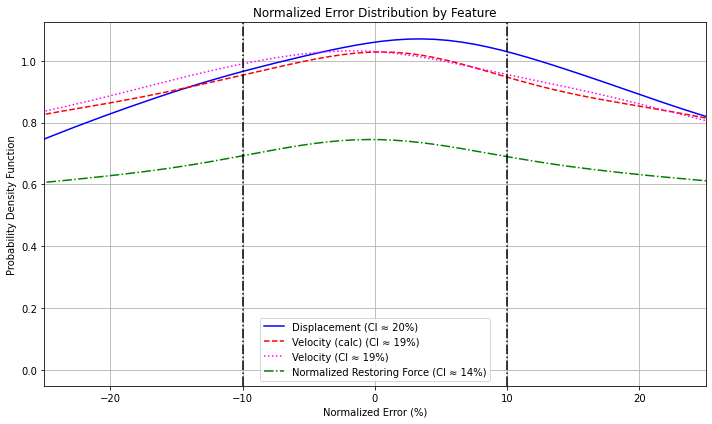

In [49]:
# Plot error probability density functions
plot_error_pdfs(pdfs_2, xlim_percent=(-25, 25))

### Regression Coefficient Histograms

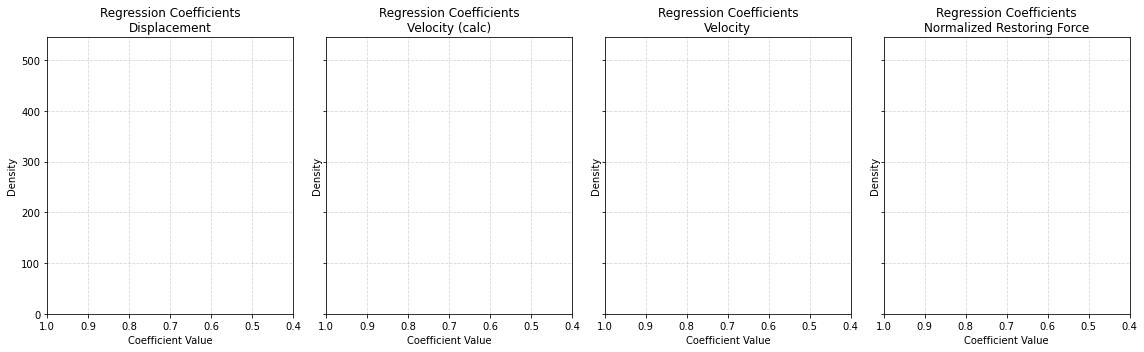

In [50]:
# Plot histograms of regression coefficients using predefined feature names and indices
plot_regression_coeff_histogram(
    Y_pred_ref_2,
    Y_pred_2,
    feature_names=feature_names_2,
    feature_indices=feature_indices_2,
    bins=20,
    xlim=(0.4, 1)
)

### Best and Worst Predictions

In [ ]:
# Select best and worst prediction samples per feature
best_worst_2 = select_best_worst_series(
    errors_2, 
    'R2', 
    top_k=3,
    feature_names=feature_names_2
)
# Display the indices and metrics of best and worst predictions
print(best_worst_2)


{'Displacement': {'best': [(13, -0.009491892304436478), (12, -0.020096677297167576), (2, -0.035265532844021674)], 'worst': [(9, -0.6776448494324498), (1, -1.8475217865229996), (7, -1.9812485471376946)]}, 'Velocity (calc)': {'best': [(8, 0.014503680202269331), (7, 0.014221318269399208), (9, 0.013282069316104761)], 'worst': [(1, 0.0049653286260167295), (3, 0.0026883747991126583), (4, -0.00017652516085009395)]}, 'Velocity': {'best': [(3, 0.03832508089364328), (10, 0.03576695351137771), (12, 0.03510664942981512)], 'worst': [(2, 0.023047423511727616), (7, 0.022416012293135168), (11, 0.019325440812122396)]}, 'Normalized Restoring Force': {'best': [(10, 0.08959870842256534), (12, 0.08893411627372827), (5, 0.08738716346726061)], 'worst': [(4, 0.08118207640356734), (13, 0.07840739013289555), (11, 0.06709176021834962)]}}


In [52]:
# Create structured dictionary for easier loop-based plotting
dict_best_worst_2 = {
    feature: {
        'best': [idx for idx, _ in best_worst_2[feature]['best']],
        'worst': [idx for idx, _ in best_worst_2[feature]['worst']]
    }
    for feature in best_worst_2
}

print(dict_best_worst_2)

{'Displacement': {'best': [13, 12, 2], 'worst': [9, 1, 7]}, 'Velocity (calc)': {'best': [8, 7, 9], 'worst': [1, 3, 4]}, 'Velocity': {'best': [3, 10, 12], 'worst': [2, 7, 11]}, 'Normalized Restoring Force': {'best': [10, 12, 5], 'worst': [4, 13, 11]}}


### Time-Series Plots: Best Predictions

############################## Best Prediction Displacement ##################################################


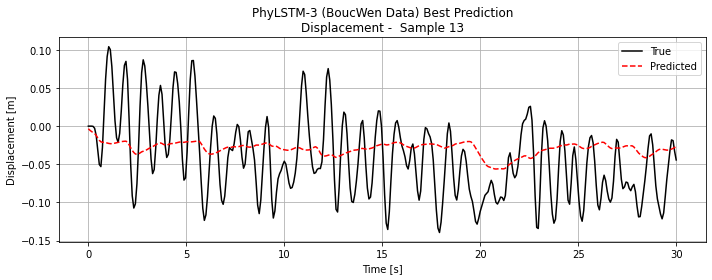

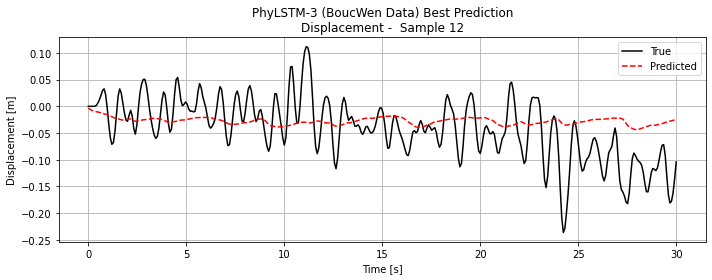

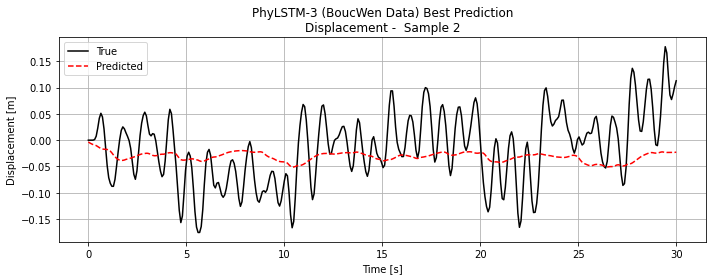

############################## Best Prediction Velocity (calc) ##################################################


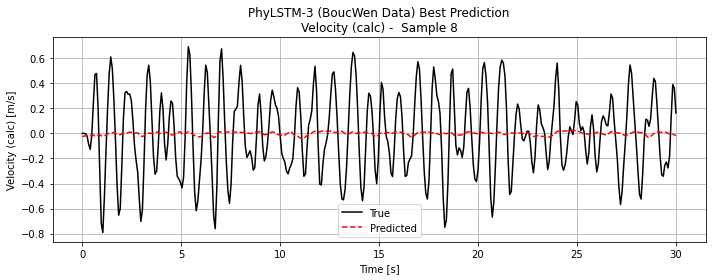

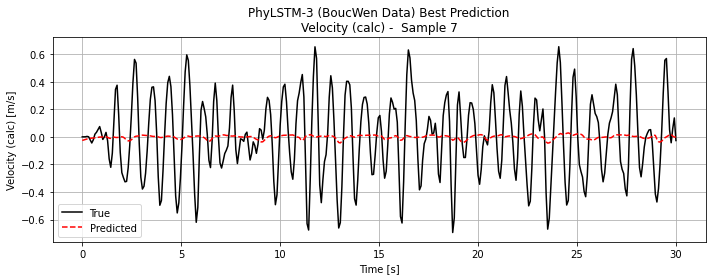

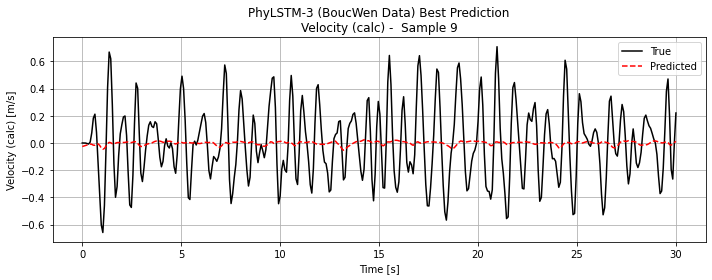

############################## Best Prediction Velocity ##################################################


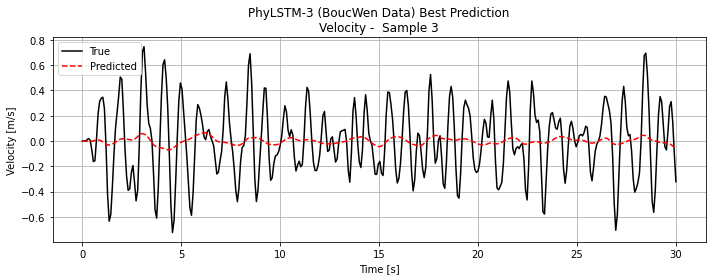

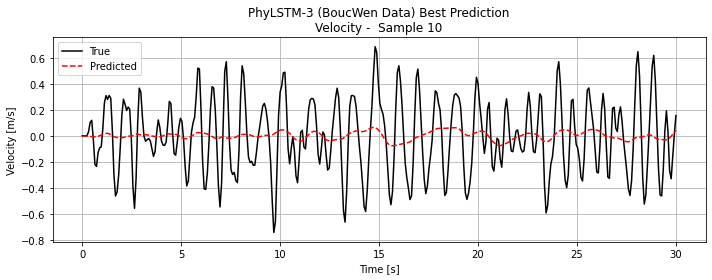

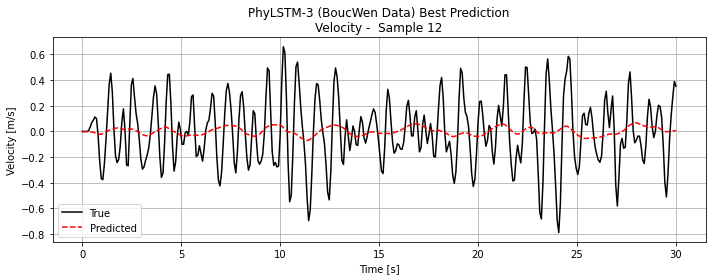

############################## Best Prediction Normalized Restoring Force ##################################################


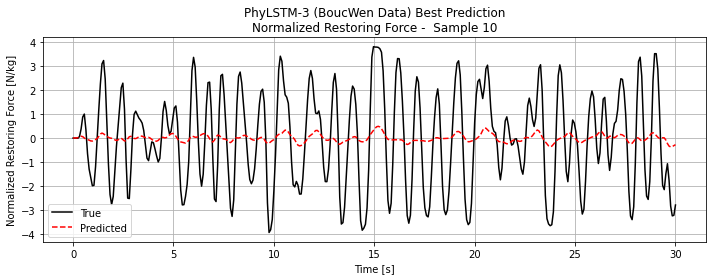

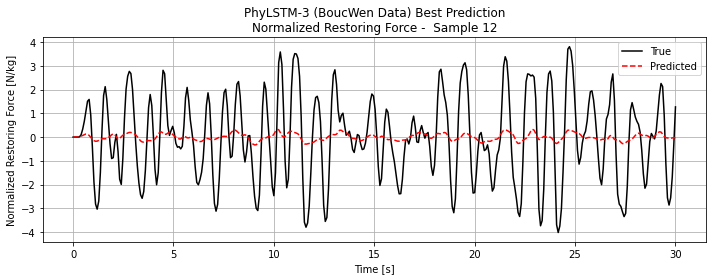

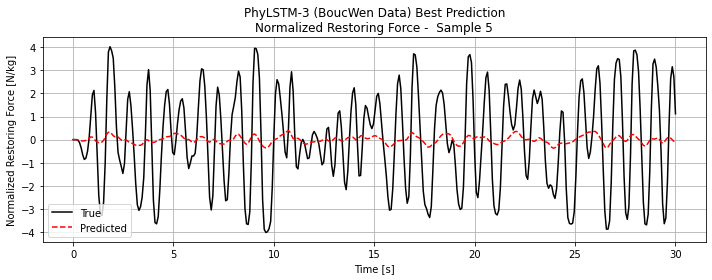

In [53]:
for i, feature in enumerate(feature_names_2):
    print('#' * 30 + f' Best Prediction {feature} ' + '#' * 50)
    plot_predictions(
        Y_pred_ref_2, Y_pred_2,
        title=f"{model_type_2} ({data_base_2}) Best Prediction\n{feature} - ",
        dt=dt_2,
        sample_indices=dict_best_worst_2[feature]['best'],
        feature_idx=i,
        feature_label=feature+' '+feature_units_2[i],
        show_original=False
    )

### Time-Series Plots: Worst Predictions

############################## Worst Prediction Displacement ##################################################


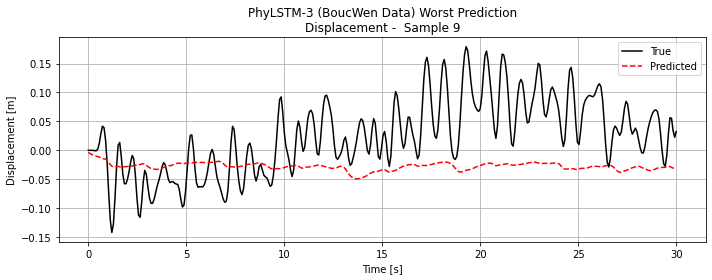

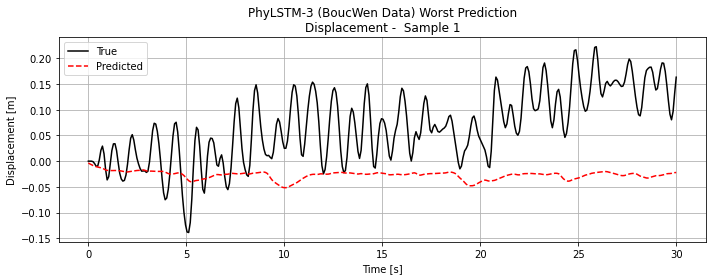

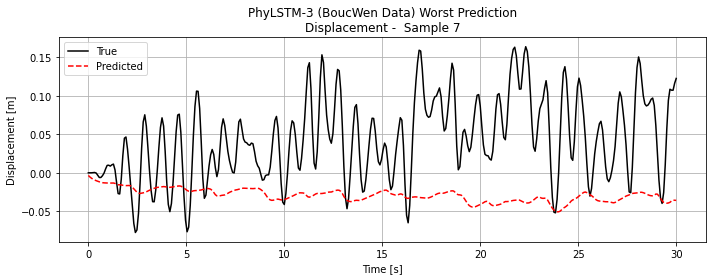

############################## Worst Prediction Velocity (calc) ##################################################


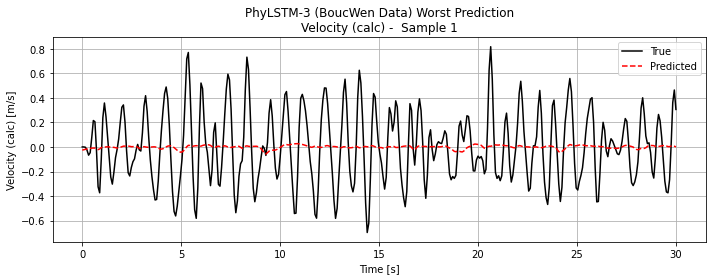

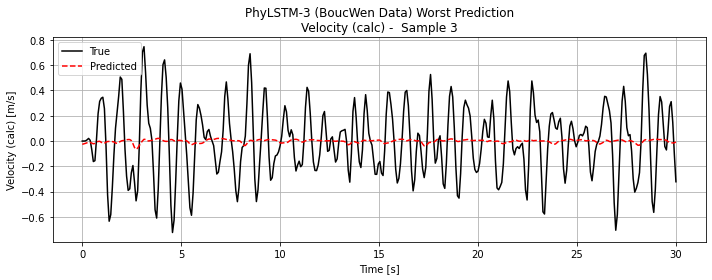

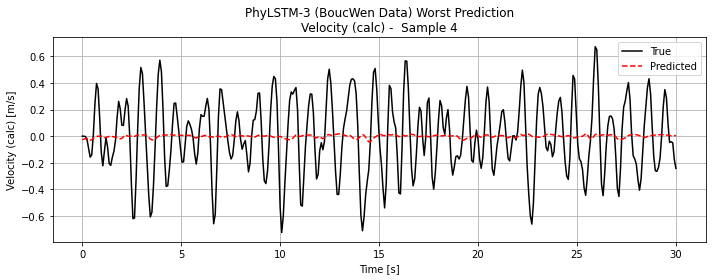

############################## Worst Prediction Velocity ##################################################


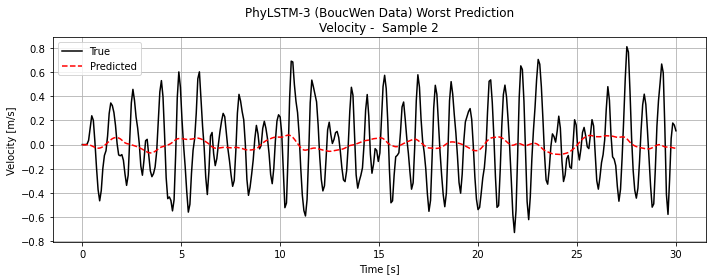

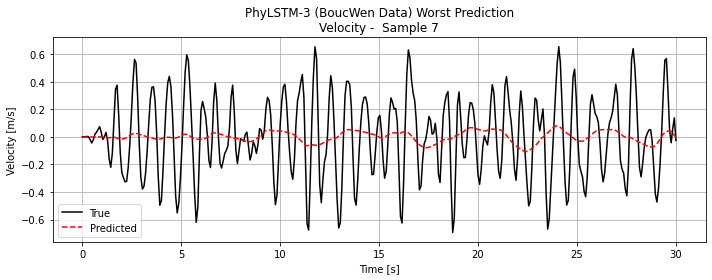

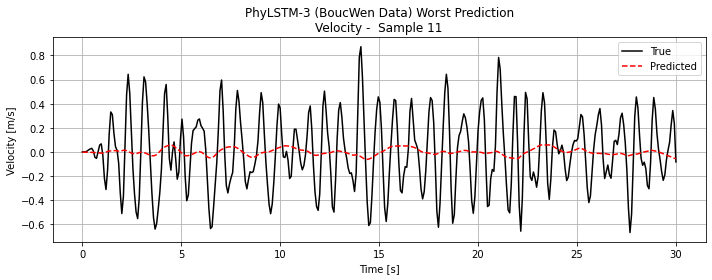

############################## Worst Prediction Normalized Restoring Force ##################################################


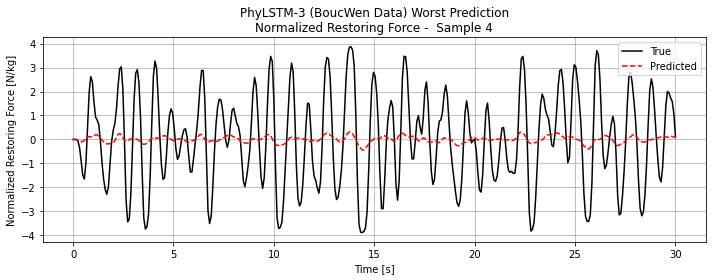

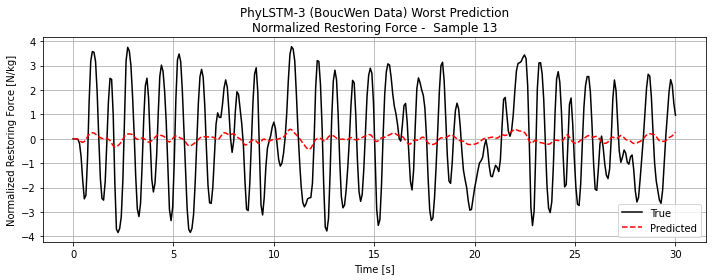

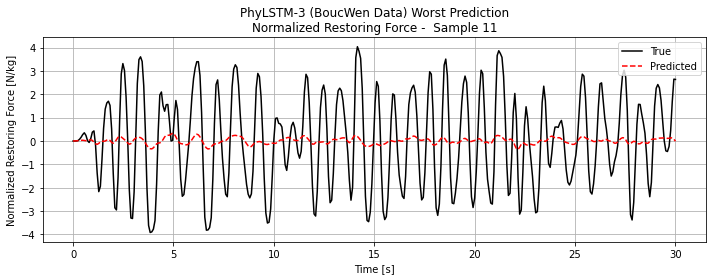

In [54]:
for i, feature in enumerate(feature_names_2):
    print('#' * 30 + f' Worst Prediction {feature} ' + '#' * 50)
    plot_predictions(
        Y_pred_ref_2, Y_pred_2,
        title=f"{model_type_2} ({data_base_2}) Worst Prediction\n{feature} - ",
        dt=dt_2,
        sample_indices=dict_best_worst_2[feature]['worst'],
        feature_idx=i,
        feature_label=feature+' '+feature_units_2[i],
        show_original=False
    )


### Save Evaluation Summary

In [55]:
# Record total end time (global, not just training)
generate_end_time = time.time()
total_runtime_global = timedelta(seconds=generate_end_time - general_start_time)
total_runtime_model_2 = generate_end_time - model_2_start_time

print(f"Total elapsed time from script start       : {total_runtime_global}")
print(f"Total elapsed time for Model 2 (from start): {timedelta(seconds=total_runtime_model_2)}")

# Define README content
readme_content_2 = ('''
    This NPZ file contains the following keys:
    - errors: Full list of error values with shape (n_samples, n_features, n_metrics, 2).\n
    - metrics: Dictionary of metric values for each evaluation metric.\n
    - best_worst_indices: Dictionary with best and worst prediction indices per feature.\n
    - description: Metadata describing the content of this file.
    '''
)

# Prepare data for saving
errors_array_2 = errors_2  # array of errors
metrics_dict_2 = df_summary_formatted_2.to_dict(orient="list")  # dictionary of metrics
best_worst_dict_2 = dict_best_worst_2  # dictionary of best and worst indices
description_str_2 = readme_content_2  # description of the saved data

# Save to .npz (using pickle for non-array objects like dicts)
output_path_2 = os.path.join(results_path_2, "model_2_all_evaluation_results.npz")
np.savez_compressed(
    output_path_2,
    errors=errors_array_2,
    metrics=np.array([metrics_dict_2], dtype=object),
    best_worst=np.array([best_worst_dict_2], dtype=object),
    description=np.array(description_str_2)
)

print(f"Saved .npz file to: {output_path_2}")


Total elapsed time from script start       : 0:01:45.634786
Total elapsed time for Model 2 (from start): 0:00:26.280288
Saved .npz file to: /home/fermandoislab/Desktop/Proyecto PINNs/Dev-PINNs-for-Nonlinear-Dynamic-Structural-Response/results/results_phylstm/phylstm3_boucwen/model_2_all_evaluation_results.npz


In [56]:
delete_all_other_variables(keep_vars)

Memory cleaned. Objects collected: 53175


53175

---
# Model 3: PhyLSTM-2 on MRFDBF data
---

## Model Definition

In [ ]:
# Type of PhyCNN model ('PhyLSTM-2' or 'PhyLSTM-3')
model_type_3 = 'PhyLSTM-2'

# Dataset identifier
data_base_3 = 'MRFDBF Data'

# Selected floor index for the MRF-DBF model prediction
floor_3 = 3  # Corresponds to the 3rd floor of the 3-DOF MRF-DBF building model

# Number of training epochs
epochs_3 = 3#10000

# Use BFGS optimization for training after initial training
use_bfgs_3 = 1 # Use BFGS optimization for training

# Batch size for training
n_data_train_3 = -1 # Use all available data for training (training indices will be used)

# Number of collocation samples
n_data_collocation_3 = 200

# Duration of data
duration = 50 # seconds

# Object Time Step
dt_3 = 0.02 # seconds

# Define the batch size for inference
batch_size_predict_3 = 8  # Adjust based on available GPU/memory

# Record the start time for Model 3’s training
model_3_start_time = time.time()

# Define path to store results
results_path_3 = project_root + '/results/results_phylstm/phylstm2_MRFDBF'
os.makedirs(results_path_3, exist_ok=True)

# Define path to save the best model for Model 3
model_path_3 = results_path_3 + '/my_best_model_phylstm2_MRFDBF.h5'

# Define path to load the MRF-DBF data
result_file_path_3 = results_path_3 + '/results_PhyLSTM2_MRFDBF.mat'

## Load Data: MRFDBF

In [58]:
# Load MATLAB data for Model 3
mat_3 = scipy.io.loadmat(project_root + '/data/raw/data_MRFDBF.mat')

# Inspect available variables
print(mat_3.keys())

dict_keys(['__header__', '__version__', '__globals__', 'Num_scale', 'input_tf', 'sample_data', 'target_tf', 'testInd', 'trainInd', 'valInd'])


In [ ]:
# Extract arrays with a unique suffix for Model 3
input_tf_3 = mat_3['input_tf']
target_tf_3 = mat_3['target_tf']
train_indices_3 = mat_3['trainInd'] - 1
valid_indices_3 = mat_3['valInd'] - 1
pred_indices_3 = mat_3['testInd'] - 1

print('-' * 100)
print(f"input_tf_3       : {str(input_tf_3.shape):<15} → Input features for the model.")
print(f"target_tf_3      : {str(target_tf_3.shape):<15} → Target outputs for the model.")
print(f"train_indices_3  : {str(train_indices_3.shape):<15} → Training indices.")
print(f"valid_indices_3  : {str(valid_indices_3.shape):<15} → Validation indices.")
print(f"pred_indices_3   : {str(pred_indices_3.shape):<15} → Prediction (test) indices.")
print('-' * 100)


----------------------------------------------------------------------------------------------------
input_tf_3       : (548, 10001)    → Input features for the model.
target_tf_3      : (548, 10001, 3) → Target outputs for the model.
train_indices_3  : (1, 47)         → Training indices.
valid_indices_3  : (1, 20)         → Validation indices.
pred_indices_3   : (1, 481)        → Prediction (test) indices.
----------------------------------------------------------------------------------------------------


In [60]:
sample_data_3 = mat_3['sample_data']

# Initialize empty lists to store processed data
ag_data_3 = []
ad_data_3 = []
u_data_3 = []
ut_data_3 = []
utt_data_3 = []

# Iterate over each sample
for i in range(sample_data_3.shape[1]):
    data_tuple = sample_data_3[0, i][0]  # access the inner structured element
    ag_data_3.append(data_tuple['ag'][0].squeeze())                 # 1D array
    ad_data_3.append(data_tuple['ad'][0].squeeze())                 # 1D array
    u_data_3.append(data_tuple['drift'][0].transpose(1, 0))         # 2D array (T x 3)
    ut_data_3.append(data_tuple['velo'][0].transpose(1, 0))      # 2D array (T x 3)
    utt_data_3.append(data_tuple['accel'][0].transpose(1, 0))    # 2D array (T x 3)

# Convert lists to NumPy arrays
ag_data_3 = np.array(ag_data_3)           # 2D array (N x T)
ad_data_3 = np.array(ad_data_3)           # 2D array (N x T)
u_data_3 = np.array(u_data_3)             # 3D array (N x T x 3)
ut_data_3 = np.array(ut_data_3)     # 3D array (N x T x 3)
utt_data_3 = np.array(utt_data_3)   # 3D array (N x T x 3)

# Convert to float32 for TensorFlow compatibility
ag_data_3 = ag_data_3.astype(np.float32)
ad_data_3 = ad_data_3.astype(np.float32)
u_data_3 = u_data_3.astype(np.float32)
ut_data_3 = ut_data_3.astype(np.float32)
utt_data_3 = utt_data_3.astype(np.float32)

# Print shape information
print('-' * 100)
print(f"ag_data_3      : {ag_data_3.shape}    → Ground accelerations (inputs).")
print(f"ad_data_3      : {ad_data_3.shape}    → Absolute displacement (output).")
print(f"u_data_3       : {u_data_3.shape} → Floor drift displacements (outputs).")
print(f"ut_data_3      : {ut_data_3.shape} → Floor relative velocities (outputs).")
print(f"utt_data_3     : {utt_data_3.shape} → Floor relative accelerations (outputs).")
print('-' * 100)


----------------------------------------------------------------------------------------------------
ag_data_3      : (548, 10001)    → Ground accelerations (inputs).
ad_data_3      : (548, 10001)    → Absolute displacement (output).
u_data_3       : (548, 10001, 3) → Floor drift displacements (outputs).
ut_data_3      : (548, 10001, 3) → Floor relative velocities (outputs).
utt_data_3     : (548, 10001, 3) → Floor relative accelerations (outputs).
----------------------------------------------------------------------------------------------------


In [61]:
# Check if ground acceleration input matches the extracted ag_data
print("Ground acceleration arrays match with input array" if np.array_equal(input_tf_3, ag_data_3) 
      else "Ground acceleration arrays do NOT match with input array.")

# Check if target drift response matches the extracted u_data
print("Target drift displacement arrays match with input array" if np.array_equal(target_tf_3, u_data_3) 
      else "Target drift displacement arrays do NOT match with target array.")


Ground acceleration arrays do NOT match with input array.
Target drift displacement arrays do NOT match with target array.


Define loaded data with known variable names

In [ ]:
# Reshape to [samples, timesteps, 1]
ag_data_3 = ag_data_3.reshape([ag_data_3.shape[0], ag_data_3.shape[1], 1])
u_data_3 = u_data_3.reshape([u_data_3.shape[0], u_data_3.shape[1], 3])
ut_data_3 = ut_data_3.reshape([ut_data_3.shape[0], ut_data_3.shape[1], 3])
utt_data_3 = utt_data_3.reshape([utt_data_3.shape[0], utt_data_3.shape[1], 3])

# Time vector
dt = duration / (ag_data_3.shape[1] - 1) # Assuming uniform time steps

# Step size for downsampling the input data
downsample_step_3 = int(dt_3/dt)  # Downsample by a factor of 4 
# Note: In the paper does not say anything about downsampling, but the original code does it, so we will do it too.

# Assign for convenience
ag_all_3 = ag_data_3[: ,::downsample_step_3]
u_all_3 = u_data_3[: ,::downsample_step_3, floor_3-1:floor_3]      # Only the third DOF (drift displacement)
ut_all_3 = ut_data_3[: ,::downsample_step_3, floor_3-1:floor_3]    # Only the third DOF (relative velocity)
utt_all_3 = utt_data_3[: ,::downsample_step_3, floor_3-1:floor_3]  # Only the third DOF (relative acceleration)
# Note: The paper does not say anything about use only the third DOF, but say the size of the output is 3, so we will use only one DOF (floor 3).
# If we do not do this, the model will not work correctly, because the memory will be too large. 

# Print shape information
print(f"dt                : {dt} s   → Original time step.")
print('-' * 100)
print(f"dt_3              : {dt_3} s   → Downsampled time step.")
print(f"downsample_step_3 : {downsample_step_3}        → Downsampling factor.")
print('-' * 100)
print(f"ag_all_3          : {ag_all_3.shape} → Ground accelerations (input).")
print(f"u_all_3           : {u_all_3.shape} → Floor displacements for 3-DOF system (output).")
print(f"ut_all_3          : {ut_all_3.shape} → Floor velocities for 3-DOF system (output).")
print(f"utt_all_3         : {utt_all_3.shape} → Floor accelerations for 3-DOF system (output).")
print(f"dt_3              : {dt_3} s → Time step.")
print('-' * 100)

dt                : 0.005 s   → Original time step.
----------------------------------------------------------------------------------------------------
dt_3              : 0.02 s   → Downsampled time step.
downsample_step_3 : 4        → Downsampling factor.
----------------------------------------------------------------------------------------------------
ag_all_3          : (548, 2501, 1) → Ground accelerations (input).
u_all_3           : (548, 2501, 1) → Floor displacements for 3-DOF system (output).
ut_all_3          : (548, 2501, 1) → Floor velocities for 3-DOF system (output).
utt_all_3         : (548, 2501, 1) → Floor accelerations for 3-DOF system (output).
dt_3              : 0.02 s → Time step.
----------------------------------------------------------------------------------------------------


**Finite Difference Matrix for Time Derivatives**

In [63]:
# Construct finite difference matrix Phi for ∂/∂t
n_3 = u_all_3.shape[1]
phi1 = np.concatenate([np.array([-3 / 2, 2, -1 / 2]), np.zeros([n_3 - 3])])
temp1 = np.concatenate([-0.5 * np.identity(n_3 - 2), np.zeros([n_3 - 2, 2])], axis=1)
temp2 = np.concatenate([np.zeros([n_3 - 2, 2]), 0.5 * np.identity(n_3 - 2)], axis=1)
phi2 = temp1 + temp2
phi3 = np.concatenate([np.zeros([n_3 - 3]), np.array([0.5, -2, 1.5])])

Phi_t0_3 = (1 / dt_3) * np.concatenate(
    [np.reshape(phi1, [1, phi1.shape[0]]), phi2, np.reshape(phi3, [1, phi3.shape[0]])], axis=0
)

Phi_t0_3 = np.reshape(Phi_t0_3, [1, n_3, n_3])

Phi_t0_3 = Phi_t0_3.astype(np.float32)  # Ensure the matrix is in float32 format for TensorFlow compatibility

print(f"Phi_t0_3 : {Phi_t0_3.shape} → Finite difference matrix for computing velocities/accelerations.")


Phi_t0_3 : (1, 2501, 2501) → Finite difference matrix for computing velocities/accelerations.


**Training Data Selection**

In [ ]:
# Subset of samples for training and validation
ag_star_3 = ag_all_3[train_indices_3[0]]#np.concatenate([train_indices_3[0], valid_indices_3[0]])] 
eta_star_3 = u_all_3[train_indices_3[0]]#[np.concatenate([train_indices_3[0], valid_indices_3[0]])]
eta_t_star_3 = ut_all_3[train_indices_3[0]]#[np.concatenate([train_indices_3[0], valid_indices_3[0]])]
eta_tt_star_3 = utt_all_3[train_indices_3[0]]#[np.concatenate([train_indices_3[0], valid_indices_3[0]])]
# Defining the training dataset using only the training set indices (47 samples).
# The validation set (20 samples) is excluded, as the paper specifies that training is performed using only 46 samples.

# Normalized force terms and right-hand side of the physical equation
g_star_3 = -eta_tt_star_3 - ag_star_3


# Subset of samples for prediction
ag_pred_3 = ag_all_3[np.concatenate([valid_indices_3[0],pred_indices_3[0]])]
u_pred_3 = u_all_3[np.concatenate([valid_indices_3[0],pred_indices_3[0]])]
ut_pred_3 = ut_all_3[np.concatenate([valid_indices_3[0],pred_indices_3[0]])]
utt_pred_3 = utt_all_3[np.concatenate([valid_indices_3[0],pred_indices_3[0]])]
# Defining the prediction dataset using the validation and test set indices,
# since the paper states that the model is trained on 46 samples and tested on the rest.
# We therefore use both the validation and test sets for prediction (note: the validation set 
# was not used during training).



# Subset of samples for collocation
ag_c_star_3 = np.concatenate([ag_star_3, ag_pred_3[0:n_data_collocation_3]])
lift_c_star_3 = -ag_c_star_3
eta_c_star_3 = np.concatenate([eta_star_3, u_pred_3[0:n_data_collocation_3]])
eta_t_c_star_3 = np.concatenate([eta_t_star_3, ut_pred_3[0:n_data_collocation_3]])
eta_tt_c_star_3 =  np.concatenate([eta_tt_star_3, utt_pred_3[0:n_data_collocation_3]])

# Assign final training variables
ag_train_3 = ag_star_3
eta_train_3 = eta_star_3
eta_t_train_3 = eta_t_star_3
eta_tt_train_3 = eta_tt_star_3
g_train_3 = g_star_3

ag_c_train_3 = ag_c_star_3
lift_train_3 = lift_c_star_3

# Repeat finite difference matrix for each collocation sample
Phi_t_3 = np.repeat(Phi_t0_3, ag_c_star_3.shape[0], axis=0)
print(f"Phi_t_3 : {Phi_t_3.shape} → Finite difference matrix for computing velocities/accelerations for collocation samples.")
print('-' * 100)

# Print training data shapes
print(f"ag_train_3     : {str(ag_train_3.shape):<15} → Ground acceleration inputs for training.")
print(f"eta_train_3    : {str(eta_train_3.shape):<15} → Displacement outputs for training.")
print(f"eta_t_train_3  : {str(eta_t_train_3.shape):<15} → Velocity outputs for training.")
print(f"eta_tt_train_3 : {str(eta_tt_train_3.shape):<15} → Acceleration variables used for training.")
print(f"g_train_3      : {str(g_train_3.shape):<15} → Restoring force (normalized) outputs for training.")
print(f"ag_c_train_3   : {str(ag_c_train_3.shape):<15} → Ground acceleration collocation data for training.")
print(f"lift_train_3   : {str(lift_train_3.shape):<15} → External acceleration inverted collocation data used for training.")
print('-' * 100)
print(f'ag_pred_3      : {ag_pred_3.shape} → Ground accelerations for prediction on unseen data (inputs).')
print(f'u_pred_3       : {u_pred_3.shape} → Floor displacements for prediction on unseen data (outputs).')
print(f'ut_pred_3      : {ut_pred_3.shape} → Floor velocities for prediction on unseen data (outputs).')
print(f'utt_pred_3     : {utt_pred_3.shape} → Floor accelerations for prediction on unseen data (outputs).')
print('-' * 100)


Phi_t_3 : (247, 2501, 2501) → Finite difference matrix for computing velocities/accelerations for collocation samples.
----------------------------------------------------------------------------------------------------
ag_train_3     : (47, 2501, 1)   → Ground acceleration inputs for training.
eta_train_3    : (47, 2501, 1)   → Displacement outputs for training.
eta_t_train_3  : (47, 2501, 1)   → Velocity outputs for training.
eta_tt_train_3 : (47, 2501, 1)   → Acceleration variables used for training.
g_train_3      : (47, 2501, 1)   → Restoring force (normalized) outputs for training.
ag_c_train_3   : (247, 2501, 1)  → Ground acceleration collocation data for training.
lift_train_3   : (247, 2501, 1)  → External acceleration inverted collocation data used for training.
----------------------------------------------------------------------------------------------------
ag_pred_3      : (481, 2501, 1) → Ground accelerations for prediction on unseen data (inputs).
u_pred_3       : (481

In [65]:
def revisar_tensores(nombre, tensor):
    print(f"{nombre} → dtype: {tensor.dtype}, contiene NaNs: {np.isnan(tensor).any()}")

revisar_tensores("ag_train_3", ag_train_3)
revisar_tensores("eta_train_3", eta_train_3)
revisar_tensores("eta_t_train_3", eta_t_train_3)
revisar_tensores("eta_tt_train_3", eta_tt_train_3)
revisar_tensores("g_train_3", g_train_3)
revisar_tensores("ag_c_train_3", ag_c_train_3)
revisar_tensores("lift_train_3", lift_train_3)
revisar_tensores("Phi_t_3", Phi_t_3)


ag_train_3 → dtype: float32, contiene NaNs: False
eta_train_3 → dtype: float32, contiene NaNs: False
eta_t_train_3 → dtype: float32, contiene NaNs: False
eta_tt_train_3 → dtype: float32, contiene NaNs: False
g_train_3 → dtype: float32, contiene NaNs: False
ag_c_train_3 → dtype: float32, contiene NaNs: False
lift_train_3 → dtype: float32, contiene NaNs: False
Phi_t_3 → dtype: float32, contiene NaNs: False


## Training for Model 3

### Model Architecture Setup

In [66]:
from models.phylstm.model_architecture_phylstm import DeepPhyLSTM2, plot_losses

# TensorFlow configuration GPU settings
config_3 = tf.ConfigProto()
config_3.gpu_options.allow_growth = True
# config_3.gpu_options.per_process_gpu_memory_fraction = 0.4
session_3 = tf.Session(config=config_3)
# tf.Session(config=tf.ConfigProto(log_device_placement=True))

# Build the model using the training data
model_3 = DeepPhyLSTM2(eta_train_3, eta_t_train_3, g_train_3, ag_train_3, ag_c_train_3, lift_train_3, Phi_t_3, save_path=model_path_3)


Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:01:00.0, compute capability: 8.6



### Training Execution

In [ ]:
# Record training start time
time_train_model_3 = time.time()

# Train the model
Loss_u, Loss_udot, Loss_g, Loss_ut_c, Loss_e, Loss, Loss_val, best_loss = model_3.train(
    num_epochs=epochs_3, 
    learning_rate=1e-3, 
    bfgs=use_bfgs_3
    )

# Save total loss
train_loss_3 = Loss
test_loss_3 = Loss_val
best_loss_3 = best_loss
all_losses_3 = {'Train_Loss': Loss, 'Loss_u': Loss_u, 'Loss_udot': Loss_udot,
                'Loss_g': Loss_g, 'Loss_ut_c': Loss_ut_c, 'Loss_e': Loss_e, 
                'Valid_Loss': Loss_val}

# Record training end time
end_model_3 = time.time()
model_3_training_time = end_model_3 - time_train_model_3

# Display total training time
print(f"Total training time for Model 3: {timedelta(seconds=model_3_training_time)}")

# Plot total training loss
plot_losses(train_loss=train_loss_3, val_loss=test_loss_3, title='Training Loss vs Validation Loss')

# Plot individual loss components
losses_3 = {
    'Total Loss': (Loss, 'blue'),                # Total training loss
    r'Loss $u$': (Loss_u, '#54ca22'),          # Loss for displacement prediction
    r'Loss $\dot{u}$': (Loss_udot, 'gold'),      # Loss for velocity prediction
    #r'Loss $g$': (Loss_g, '#fe9c16'),           # Loss for normalized restoring force prediction (don't use this)
    r'Loss $u_t(c)$': (Loss_ut_c, "#07b4c7"),  # Loss for velocity estimation from predicted displacements
    r'Loss $f(c)$': (Loss_e, "#71087f")       # Loss for normalized equation of motion
}

plot_losses(other_losses=losses_3, title='Training Loss Components')


## Prediction

### Prediction on Known (Training) Data

In [ ]:
# Inputs used during training
X_train_3 = ag_all_3[train_indices_3[0]]  # Use only the training set indices (47 samples)
# Note: The validation set (20 samples) is excluded, as the paper specifies that training is performed using only 46 samples.

# True reference values
y_train_ref_3 = u_all_3[train_indices_3[0]]
yt_train_ref_3 = ut_all_3[train_indices_3[0]]
ytt_train_ref_3 = utt_all_3[train_indices_3[0]]
lift_train_ref_3 = -X_train_3
g_train_ref_3 = -ytt_train_ref_3 + lift_train_ref_3

# Predict using trained model
eta, eta_t, eta_tt, eta_dot, g = model_3.predict(X_train_3, np.repeat(Phi_t0_3, len(X_train_3), axis=0))

lift = model_3.predict_c(X_train_3, np.repeat(Phi_t0_3, len(X_train_3), axis=0))

# Assign predictions
y_train_pred_3 = eta
yt_train_pred_3 = eta_t
ytt_train_pred_3 = eta_tt
ydot_train_pred_3 = eta_dot
g_train_pred_3 = -eta_tt + lift

# Print shapes of training prediction results
print(f"X_train_3         : {str(X_train_3.shape):<15} → External accelerations (input).")
print('-' * 100)
print(f"y_train_ref_3     : {str(y_train_ref_3.shape):<15} → Reference displacements.")
print(f"yt_train_ref_3    : {str(yt_train_ref_3.shape):<15} → Reference velocities.")
print(f"g_train_ref_3     : {str(g_train_ref_3.shape):<15} → Reference restoring forces.")
print('-' * 100)
print(f"y_train_pred_3    : {str(y_train_pred_3.shape):<15} → Predicted displacements.")
print(f"yt_train_pred_3   : {str(yt_train_pred_3.shape):<15} → Predicted ∂u/∂t.")
print(f"ydot_train_pred_3 : {str(ydot_train_pred_3.shape):<15} → Predicted velocities.")
print(f"g_train_pred_3    : {str(g_train_pred_3.shape):<15} → Predicted restoring forces.")

### Prediction on Unseen (Test) Data

In [ ]:
# Prepare full unseen prediction data
X_pred_3 = ag_all_3[np.concatenate([valid_indices_3[0], pred_indices_3[0]])]  # Use both validation and test indices
# Note: The paper states that the model is trained on 46 samples and tested on the rest.

# Reference (ground truth) values
y_pred_ref_3 = u_all_3[np.concatenate([valid_indices_3[0], pred_indices_3[0]])]
yt_pred_ref_3 = ut_all_3[np.concatenate([valid_indices_3[0], pred_indices_3[0]])]
ytt_pred_ref_3 = utt_all_3[np.concatenate([valid_indices_3[0], pred_indices_3[0]])]
lift_pred_ref_3 = -X_pred_3
g_pred_ref_3 = -ytt_pred_ref_3 + lift_pred_ref_3

# Initialize lists to collect predictions
eta_all, eta_t_all, eta_tt_all, eta_dot_all, g_all, lift_all = [], [], [], [], [], []

# Perform prediction in batches
for i in range(0, len(X_pred_3), batch_size_predict_3):
    X_batch = X_pred_3[i:i + batch_size_predict_3]
    Phi_batch = np.repeat(Phi_t0_3, len(X_batch), axis=0)

    # Forward pass through the trained model
    eta, eta_t, eta_tt, eta_dot, g = model_3.predict(X_batch, Phi_batch)
    lift = model_3.predict_c(X_batch, Phi_batch)

    # Store predictions
    eta_all.append(eta)
    eta_t_all.append(eta_t)
    eta_tt_all.append(eta_tt)
    eta_dot_all.append(eta_dot)
    g_all.append(g)
    lift_all.append(lift)

# Concatenate batch-wise predictions
y_pred_3 = np.concatenate(eta_all, axis=0)
yt_pred_3 = np.concatenate(eta_t_all, axis=0)
ytt_pred_3 = np.concatenate(eta_tt_all, axis=0)
ydot_pred_3 = np.concatenate(eta_dot_all, axis=0)
g_pred_3 = -ytt_pred_3 + np.concatenate(lift_all, axis=0)

# Print output shapes for verification
print(f"X_pred_3        : {str(X_pred_3.shape):<15} → External accelerations (input unseen).")
print('-' * 100)
print(f"y_pred_ref_3    : {str(y_pred_ref_3.shape):<15} → Reference displacements (unseen).")
print(f"yt_pred_ref_3   : {str(yt_pred_ref_3.shape):<15} → Reference velocities (unseen).")
print(f"g_pred_ref_3    : {str(g_pred_ref_3.shape):<15} → Reference restoring forces (unseen).")
print('-' * 100)
print(f"y_pred_3        : {str(y_pred_3.shape):<15} → Predicted displacements (unseen).")
print(f"yt_pred_3       : {str(yt_pred_3.shape):<15} → Predicted ∂u/∂t (unseen).")
print(f"ydot_pred_3     : {str(ydot_pred_3.shape):<15} → Predicted velocities (unseen).")
print(f"g_pred_3        : {str(g_pred_3.shape):<15} → Predicted restoring forces (unseen).")


## Save Essential Results

In [ ]:
# Record final time and compute elapsed time
model_3_end_time = time.time()
model_3_running_time = model_3_end_time - model_3_start_time
elapsed_time_model_3 = timedelta(seconds=model_3_running_time)
print(f"Total elapsed time for Model 3 -> {elapsed_time_model_3}")


In [68]:
# Create a descriptive text explaining each saved variable
variable_descriptions_3 = '''
- X_train_3: Training inputs (external ground accelerations).
- y_train_ref_3: True displacement outputs used during training.
- yt_train_ref_3: True velocity outputs used during training.
- g_train_ref_3: True restoring force targets during training.

- y_train_pred_3: Predicted displacements on training data.
- yt_train_pred_3: Predicted ∂u/∂t values on training data.
- ydot_train_pred_3: Predicted velocity outputs on training data.
- g_train_pred_3: Predicted restoring force outputs on training data.

- X_pred_3: Input ground accelerations for prediction on unseen data.
- y_pred_ref_3: True displacements for unseen data.
- yt_pred_ref_3: True velocities for unseen data.
- g_pred_ref_3: True restoring forces for unseen data.

- y_pred_3: Predicted displacements for unseen data.
- yt_pred_3: Predicted ∂u/∂t for unseen data.
- ydot_pred_3: Predicted velocities for unseen data.
- g_pred_3: Predicted restoring forces for unseen data.

- train_loss_3: Total loss during training.
- all_losses_3: Dictionary containing individual loss components. (Loss: Total training loss, 
                                                                   Loss_u: Loss for displacement prediction, 
                                                                   Loss_udot: Loss for velocity prediction, 
                                                                   Loss_g: Loss for normalized restoring force prediction, 
                                                                   Loss_ut_c: Loss for velocity estimation from predicted displacements on collocation data, 
                                                                   Loss_e: Loss for normalized equation of motion on collocation data)
- Phi_t_3: Finite difference matrix used for time derivatives.
- model_3_running_time: Total execution time of the model (in seconds).
- epochs_3: Number of training epochs.
'''

In [69]:
# Save all relevant variables into a MATLAB file
scipy.io.savemat(
    result_file_path_3,
    {
        'X_train_3': X_train_3,
        'y_train_ref_3': y_train_ref_3,
        'yt_train_ref_3': yt_train_ref_3,
        'g_train_ref_3': g_train_ref_3,
        
        'y_train_pred_3': y_train_pred_3,
        'yt_train_pred_3': yt_train_pred_3,
        'ydot_train_pred_3': ydot_train_pred_3,
        'g_train_pred_3': g_train_pred_3,
        
        'X_pred_3': X_pred_3,
        'y_pred_ref_3': y_pred_ref_3,
        'yt_pred_ref_3': yt_pred_ref_3,
        'g_pred_ref_3': g_pred_ref_3,
        
        'y_pred_3': y_pred_3,
        'yt_pred_3': yt_pred_3,
        'ydot_pred_3': ydot_pred_3,
        'g_pred_3': g_pred_3,
        
        'train_loss_3': train_loss_3,
        'all_losses_3': all_losses_3,
        'Phi_t_3': Phi_t_3,
        'model_3_running_time': model_3_training_time,
        'epochs_3': epochs_3,
        'variable_descriptions_3': variable_descriptions_3
    }
)


## Results

In [70]:
from utils.evaluation_models import (
    calculate_errors_with_pdf,
    format_metrics_df,
    plot_error_pdfs,
    plot_regression_coeff_histogram,
    select_best_worst_series,
    plot_predictions
)

# Define feature names and indices to reuse in evaluation and plotting
feature_names_3 = [f'Displacement {floor_3}-DOF', f'Velocity (calc) {floor_3}-DOF', f'Velocity {floor_3}-DOF', f'Normalized Restoring Force {floor_3}-DOF']
feature_units_3 = [         '[m]',           '[m/s]',    '[m/s]',                        '[N/kg]']
feature_indices_3 = [0, 1, 2, 3]

### Concatenate Prediction Outputs

In [ ]:
# Concatenate predictions and reference outputs for joint evaluation
Y_pred_ref_3 = np.concatenate([y_pred_ref_3, yt_pred_ref_3, yt_pred_ref_3, g_pred_ref_3], axis=2)
Y_pred_3 = np.concatenate([y_pred_3, yt_pred_3, ydot_pred_3, g_pred_3], axis=2)

print(f"Y_pred_ref_3 : {Y_pred_ref_3.shape} → Reference outputs (Displacement, Velocity       , Velocity, Normalized Force)")
print(f"Y_pred_3     : {Y_pred_3.shape} → Predicted outputs (Displacement, Velocity (calc), Velocity, Normalized Force)")


### Evaluation Metrics

In [ ]:
# Calculate Evaluation Metrics and PDFs for each feature
df_summary_3, errors_3, pdfs_3 = calculate_errors_with_pdf(
    Y_pred_ref_3, Y_pred_3,
    feature_names=feature_names_3
)

# Print unformatted metrics
print(df_summary_3)

In [ ]:
# Format and display metrics
df_summary_formatted_3 = format_metrics_df(
    df_summary_3,
    metric_names=['R2', 'Pearson_r', 'NormError', 'MSE', 'MAE']
)
df_summary_formatted_3

### Probability Density of Errors

In [ ]:
# Plot error probability density functions
plot_error_pdfs(pdfs_3, xlim_percent=(-25, 25))

### Regression Coefficient Histograms

In [ ]:
# Plot histograms of regression coefficients using predefined feature names and indices
plot_regression_coeff_histogram(
    Y_pred_ref_3,
    Y_pred_3,
    feature_names=feature_names_3,
    feature_indices=feature_indices_3,
    bins=20,
    xlim=(0.4, 1)
)

### Best and Worst Predictions

In [ ]:
# Select best and worst prediction samples per feature
best_worst_3 = select_best_worst_series(
    errors_3, 
    'R2', 
    top_k=3,
    feature_names=feature_names_3
)
# Display the indices and metrics of best and worst predictions
print(best_worst_3)


In [ ]:
# Create structured dictionary for easier loop-based plotting
dict_best_worst_3 = {
    feature: {
        'best': [idx for idx, _ in best_worst_3[feature]['best']],
        'worst': [idx for idx, _ in best_worst_3[feature]['worst']]
    }
    for feature in best_worst_3
}

print(dict_best_worst_3)

### Time-Series Plots: Best Predictions

In [ ]:
for i, feature in enumerate(feature_names_3):
    print('#' * 30 + f' Best Prediction {feature} ' + '#' * 50)
    plot_predictions(
        Y_pred_ref_3, Y_pred_3,
        title=f"{model_type_3} ({data_base_3}) Best Prediction\n{feature} - ",
        dt=dt_3,
        sample_indices=dict_best_worst_3[feature]['best'],
        feature_idx=i,
        feature_label=feature+' '+feature_units_3[i],
        show_original=False
    )

### Time-Series Plots: Worst Predictions

In [ ]:
for i, feature in enumerate(feature_names_3):
    print('#' * 30 + f' Worst Prediction {feature} ' + '#' * 50)
    plot_predictions(
        Y_pred_ref_3, Y_pred_3,
        title=f"{model_type_3} ({data_base_3}) Worst Prediction\n{feature} - ",
        dt=dt_3,
        sample_indices=dict_best_worst_3[feature]['worst'],
        feature_idx=i,
        feature_label=feature+' '+feature_units_3[i],
        show_original=False
    )


### Save Evaluation Summary

In [ ]:
# Record total end time (global, not just training)
generate_end_time = time.time()
total_runtime_global = timedelta(seconds=generate_end_time - general_start_time)
total_runtime_model_3 = generate_end_time - model_3_start_time

print(f"Total elapsed time from script start       : {total_runtime_global}")
print(f"Total elapsed time for Model 3 (from start): {timedelta(seconds=total_runtime_model_3)}")

# Define README content
readme_content_3 = ('''
    This NPZ file contains the following keys:
    - errors: Full list of error values with shape (n_samples, n_features, n_metrics, 2).\n
    - metrics: Dictionary of metric values for each evaluation metric.\n
    - best_worst_indices: Dictionary with best and worst prediction indices per feature.\n
    - description: Metadata describing the content of this file.
    '''
)

# Prepare data for saving
errors_array_3 = errors_3  # array of errors
metrics_dict_3 = df_summary_formatted_3.to_dict(orient="list")  # dictionary of metrics
best_worst_dict_3 = dict_best_worst_3  # dictionary of best and worst indices
description_str_3 = readme_content_3  # description of the saved data

# Save to .npz (using pickle for non-array objects like dicts)
output_path_3 = os.path.join(results_path_3, "model_3_all_evaluation_results.npz")
np.savez_compressed(
    output_path_3,
    errors=errors_array_3,
    metrics=np.array([metrics_dict_3], dtype=object),
    best_worst=np.array([best_worst_dict_3], dtype=object),
    description=np.array(description_str_3)
)

print(f"Saved .npz file to: {output_path_3}")


In [ ]:
delete_all_other_variables(keep_vars)

---
# Model 4: PhyLSTM-3 on MRFDBF data
---

## Model Definition

In [ ]:
# Type of PhyCNN model ('PhyLSTM-2' or 'PhyLSTM-3')
model_type_4 = 'PhyLSTM-3'

# Dataset identifier
data_base_4 = 'MRFDBF Data'

# Selected floor index for the MRF-DBF model prediction
floor_4 = 3  # Corresponds to the 3rd floor of the 3-DOF MRF-DBF building model

# Number of training epochs
epochs_4 = 3#10000

# Use BFGS optimization for training after initial training
use_bfgs_4 = 1 # Use BFGS optimization for training

# Batch size for training
n_data_train_4 = -1 # Use all available data for training (training indices will be used)

# Number of collocation samples
n_data_collocation_4 = 200

# Duration of data
duration = 50 # seconds

# Object Time Step
dt_4 = 0.02 # seconds

# Define the batch size for inference
batch_size_predict_4 = 8  # Adjust based on available GPU/memory

# Record the start time for Model 4’s training
model_4_start_time = time.time()

# Define path to store results
results_path_4 = project_root + '/results/results_phylstm/phylstm3_MRFDBF'
os.makedirs(results_path_4, exist_ok=True)

# Define path to save the best model for Model 4
model_path_4 = results_path_4 + '/my_best_model_phylstm3_MRFDBF.h5'

# Define path to save the MRF-DBF data
result_file_path_4 = results_path_4 + '/results_PhyLSTM3_MRFDBF.mat'

## Load Data: MRFDBF

In [ ]:
# Load MATLAB data for Model 4
mat_4 = scipy.io.loadmat(project_root + '/data/raw/data_MRFDBF.mat')

# Inspect available variables
print(mat_4.keys())

In [ ]:
# Extract arrays with a unique suffix for Model 4
input_tf_4 = mat_4['input_tf']
target_tf_4 = mat_4['target_tf']
train_indices_4 = mat_4['trainInd'] - 1
valid_indices_4 = mat_4['valInd'] - 1
pred_indices_4 = mat_4['testInd'] - 1
sample_data_4 = mat_4['sample_data']

print('-' * 100)
print(f"input_tf_4       : {str(input_tf_4.shape):<15} → Input features for the model.")
print(f"target_tf_4      : {str(target_tf_4.shape):<15} → Target outputs for the model.")
print(f"train_indices_4  : {str(train_indices_4.shape):<15} → Training indices.")
print(f"valid_indices_4  : {str(valid_indices_4.shape):<15} → Validation indices.")
print(f"pred_indices_4   : {str(pred_indices_4.shape):<15} → Prediction (test) indices.")
print(f"sample_data_4    : {str(sample_data_4.shape):<15} → Sample data containing ground acceleration, drift, velocity, and acceleration.")
print('-' * 100)


In [ ]:
# Initialize empty lists to store processed data
ag_data_4 = []
ad_data_4 = []
u_data_4 = []
ut_data_4 = []
utt_data_4 = []

# Iterate over each sample
for i in range(sample_data_4.shape[1]):
    data_tuple = sample_data_4[0, i][0]  # access the inner structured element
    ag_data_4.append(data_tuple['ag'][0].squeeze())                 # 1D array
    ad_data_4.append(data_tuple['ad'][0].squeeze())                 # 1D array
    u_data_4.append(data_tuple['drift'][0].transpose(1, 0))         # 2D array (T x 3)
    ut_data_4.append(data_tuple['velo'][0].transpose(1, 0))      # 2D array (T x 3)
    utt_data_4.append(data_tuple['accel'][0].transpose(1, 0))    # 2D array (T x 3)

# Convert lists to NumPy arrays
ag_data_4 = np.array(ag_data_4)           # 2D array (N x T)
ad_data_4 = np.array(ad_data_4)           # 2D array (N x T)
u_data_4 = np.array(u_data_4)             # 3D array (N x T x 3)
ut_data_4 = np.array(ut_data_4)     # 3D array (N x T x 3)
utt_data_4 = np.array(utt_data_4)   # 3D array (N x T x 3)

# Convert to float32 for TensorFlow compatibility
ag_data_4 = ag_data_4.astype(np.float32)
ad_data_4 = ad_data_4.astype(np.float32)
u_data_4 = u_data_4.astype(np.float32)
ut_data_4 = ut_data_4.astype(np.float32)
utt_data_4 = utt_data_4.astype(np.float32)

# Print shape information
print('-' * 100)
print(f"ag_data_4      : {ag_data_4.shape}    → Ground accelerations (inputs).")
print(f"ad_data_4      : {ad_data_4.shape}    → Absolute displacement (output).")
print(f"u_data_4       : {u_data_4.shape} → Floor drift displacements (outputs).")
print(f"ut_data_4      : {ut_data_4.shape} → Floor relative velocities (outputs).")
print(f"utt_data_4     : {utt_data_4.shape} → Floor relative accelerations (outputs).")
print('-' * 100)


In [ ]:
# Check if ground acceleration input matches the extracted ag_data
print("Ground acceleration arrays match with input array" if np.array_equal(input_tf_4, ag_data_4) 
      else "Ground acceleration arrays do NOT match with input array.")

# Check if target drift response matches the extracted u_data
print("Target drift displacement arrays match with input array" if np.array_equal(target_tf_4, u_data_4) 
      else "Target drift displacement arrays do NOT match with target array.")


Define loaded data with known variable names

In [ ]:
# Reshape to [samples, timesteps, 1]
ag_data_4 = ag_data_4.reshape([ag_data_4.shape[0], ag_data_4.shape[1], 1])
u_data_4 = u_data_4.reshape([u_data_4.shape[0], u_data_4.shape[1], 3])
ut_data_4 = ut_data_4.reshape([ut_data_4.shape[0], ut_data_4.shape[1], 3])
utt_data_4 = utt_data_4.reshape([utt_data_4.shape[0], utt_data_4.shape[1], 3])

# Time vector
dt = duration / (ag_data_4.shape[1] - 1) # Assuming uniform time steps

# Step size for downsampling the input data
downsample_step_4 = int(dt_4/dt)  # Downsample by a factor of 4 
# Note: In the paper does not say anything about downsampling, but the original code does it, so we will do it too.

# Assign for convenience
ag_all_4 = ag_data_4[: ,::downsample_step_4]
u_all_4 = u_data_4[: ,::downsample_step_4, floor_4-1:floor_4]      # Only the third DOF (drift displacement)
ut_all_4 = ut_data_4[: ,::downsample_step_4, floor_4-1:floor_4]    # Only the third DOF (relative velocity)
utt_all_4 = utt_data_4[: ,::downsample_step_4, floor_4-1:floor_4]  # Only the third DOF (relative acceleration)
# Note: The paper does not say anything about use only the third DOF, but say the size of the output is 3, so we will use only one DOF (floor 3).

# Print shape information
print(f"dt                : {dt} s   → Original time step.")
print('-' * 100)
print(f"dt_4              : {dt_4} s   → Downsampled time step.")
print(f"downsample_step_4 : {downsample_step_4}        → Downsampling factor.")
print('-' * 100)
print(f"ag_all_4          : {ag_all_4.shape} → Ground accelerations (input).")
print(f"u_all_4           : {u_all_4.shape} → Floor displacements for 3-DOF system (output).")
print(f"ut_all_4          : {ut_all_4.shape} → Floor velocities for 3-DOF system (output).")
print(f"utt_all_4         : {utt_all_4.shape} → Floor accelerations for 3-DOF system (output).")
print(f"dt_4              : {dt_4} s → Time step.")
print('-' * 100)

**Finite Difference Matrix for Time Derivatives**

In [ ]:
# Construct finite difference matrix Phi for ∂/∂t
n_4 = u_all_4.shape[1]
phi1 = np.concatenate([np.array([-3 / 2, 2, -1 / 2]), np.zeros([n_4 - 3])])
temp1 = np.concatenate([-0.5 * np.identity(n_4 - 2), np.zeros([n_4 - 2, 2])], axis=1)
temp2 = np.concatenate([np.zeros([n_4 - 2, 2]), 0.5 * np.identity(n_4 - 2)], axis=1)
phi2 = temp1 + temp2
phi3 = np.concatenate([np.zeros([n_4 - 3]), np.array([0.5, -2, 1.5])])

Phi_t0_4 = (1 / dt_4) * np.concatenate(
    [np.reshape(phi1, [1, phi1.shape[0]]), phi2, np.reshape(phi3, [1, phi3.shape[0]])], axis=0
)

Phi_t0_4 = np.reshape(Phi_t0_4, [1, n_4, n_4])

Phi_t0_4 = Phi_t0_4.astype(np.float32)  # Ensure the matrix is in float32 format for TensorFlow compatibility

print(f"Phi_t0_4 : {Phi_t0_4.shape} → Finite difference matrix for computing velocities/accelerations.")


**Training Data Selection**

In [ ]:
# Subset of samples for training and validation
ag_star_4 = ag_all_4[train_indices_4[0]]#np.concatenate([train_indices_4[0], valid_indices_4[0]])] 
eta_star_4 = u_all_4[train_indices_4[0]]#[np.concatenate([train_indices_4[0], valid_indices_4[0]])]
eta_t_star_4 = ut_all_4[train_indices_4[0]]#[np.concatenate([train_indices_4[0], valid_indices_4[0]])]
eta_tt_star_4 = utt_all_4[train_indices_4[0]]#[np.concatenate([train_indices_4[0], valid_indices_4[0]])]
# Defining the training dataset using only the training set indices (47 samples).
# The validation set (20 samples) is excluded, as the paper specifies that training is performed using only 46 samples.

# Normalized force terms and right-hand side of the physical equation
g_star_4 = -eta_tt_star_4 - ag_star_4


# Subset of samples for prediction
ag_pred_4 = ag_all_4[np.concatenate([valid_indices_4[0],pred_indices_4[0]])]
u_pred_4 = u_all_4[np.concatenate([valid_indices_4[0],pred_indices_4[0]])]
ut_pred_4 = ut_all_4[np.concatenate([valid_indices_4[0],pred_indices_4[0]])]
utt_pred_4 = utt_all_4[np.concatenate([valid_indices_4[0],pred_indices_4[0]])]
# Defining the prediction dataset using the validation and test set indices,
# since the paper states that the model is trained on 46 samples and tested on the rest.
# We therefore use both the validation and test sets for prediction (note: the validation set 
# was not used during training).



# Subset of samples for collocation
ag_c_star_4 = np.concatenate([ag_star_4, ag_pred_4[0:n_data_collocation_4]])
lift_c_star_4 = -ag_c_star_4
eta_c_star_4 = np.concatenate([eta_star_4, u_pred_4[0:n_data_collocation_4]])
eta_t_c_star_4 = np.concatenate([eta_t_star_4, ut_pred_4[0:n_data_collocation_4]])
eta_tt_c_star_4 =  np.concatenate([eta_tt_star_4, utt_pred_4[0:n_data_collocation_4]])

# Assign final training variables
ag_train_4 = ag_star_4
eta_train_4 = eta_star_4
eta_t_train_4 = eta_t_star_4
eta_tt_train_4 = eta_tt_star_4
g_train_4 = g_star_4

ag_c_train_4 = ag_c_star_4
lift_train_4 = lift_c_star_4

# Repeat finite difference matrix for each collocation sample
Phi_t_4 = np.repeat(Phi_t0_4, ag_c_star_4.shape[0], axis=0)
print(f"Phi_t_4 : {Phi_t_4.shape} → Finite difference matrix for computing velocities/accelerations for collocation samples.")
print('-' * 100)

# Print training data shapes
print(f"ag_train_4     : {str(ag_train_4.shape):<15} → Ground acceleration inputs for training.")
print(f"eta_train_4    : {str(eta_train_4.shape):<15} → Displacement outputs for training.")
print(f"eta_t_train_4  : {str(eta_t_train_4.shape):<15} → Velocity outputs for training.")
print(f"eta_tt_train_4 : {str(eta_tt_train_4.shape):<15} → Acceleration variables used for training.")
print(f"g_train_4      : {str(g_train_4.shape):<15} → Restoring force (normalized) outputs for training.")
print(f"ag_c_train_4   : {str(ag_c_train_4.shape):<15} → Ground acceleration collocation data for training.")
print(f"lift_train_4   : {str(lift_train_4.shape):<15} → External acceleration inverted collocation data used for training.")
print('-' * 100)
print(f'ag_pred_4      : {ag_pred_4.shape} → Ground accelerations for prediction on unseen data (inputs).')
print(f'u_pred_4       : {u_pred_4.shape} → Floor displacements for prediction on unseen data (outputs).')
print(f'ut_pred_4      : {ut_pred_4.shape} → Floor velocities for prediction on unseen data (outputs).')
print(f'utt_pred_4     : {utt_pred_4.shape} → Floor accelerations for prediction on unseen data (outputs).')
print('-' * 100)


In [ ]:
def revisar_tensores(nombre, tensor):
    print(f"{nombre} → dtype: {tensor.dtype}, contiene NaNs: {np.isnan(tensor).any()}")

revisar_tensores("ag_train_4", ag_train_4)
revisar_tensores("eta_train_4", eta_train_4)
revisar_tensores("eta_t_train_4", eta_t_train_4)
revisar_tensores("eta_tt_train_4", eta_tt_train_4)
revisar_tensores("g_train_4", g_train_4)
revisar_tensores("ag_c_train_4", ag_c_train_4)
revisar_tensores("lift_train_4", lift_train_4)
revisar_tensores("Phi_t_4", Phi_t_4)


## Training for Model 4

### Model Architecture Setup

In [ ]:
from models.phylstm.model_architecture_phylstm import DeepPhyLSTM3, plot_losses

# TensorFlow configuration GPU settings
config_4 = tf.ConfigProto()
config_4.gpu_options.allow_growth = True
# config_4.gpu_options.per_process_gpu_memory_fraction = 0.4
session_4 = tf.Session(config=config_4)
# tf.Session(config=tf.ConfigProto(log_device_placement=True))

# Build the model using the training data
model_4 = DeepPhyLSTM3(eta_train_4, eta_t_train_4, g_train_4, ag_train_4, ag_c_train_4, lift_train_4, Phi_t_4)


### Training Execution

In [ ]:
# Record training start time
time_train_model_4 = time.time()

# Train the model
Loss_u, Loss_udot, Loss_g, Loss_ut_c, Loss_gt_c, Loss_e, Loss, Loss_val, best_loss = model_4.train(
    num_epochs=epochs_4, 
    learning_rate=1e-3, 
    bfgs=use_bfgs_4
    )

# Save total loss
train_loss_4 = Loss
test_loss_4 = Loss_val
best_loss_4 = best_loss
all_losses_4 = {'Train_Loss': Loss, 'Loss_u': Loss_u, 'Loss_udot': Loss_udot,
                'Loss_g': Loss_g, 'Loss_ut_c': Loss_ut_c, 'Loss_e': Loss_e, 
                'Loss_gt_c': Loss_gt_c,
                'Valid_Loss': Loss_val}

# Record training end time
end_model_4 = time.time()
model_4_training_time = end_model_4 - time_train_model_4

# Display total training time
print(f"Total training time for Model 4: {timedelta(seconds=model_4_training_time)}")

# Plot total training loss
plot_losses(train_loss=train_loss_4, val_loss=test_loss_4, title='Training Loss vs Validation Loss')

# Plot individual loss components
losses_4 = {
    'Total Loss': (Loss, 'blue'),                # Total training loss
    r'Loss $u$': (Loss_u, '#54ca22'),          # Loss for displacement prediction
    r'Loss $\dot{u}$': (Loss_udot, 'gold'),      # Loss for velocity prediction
    #r'Loss $g$': (Loss_g, '#fe9c16'),           # Loss for normalized restoring force prediction (don't use this)
    r'Loss $u_t(c)$': (Loss_ut_c, "#07b4c7"),  # Loss for velocity estimation from predicted displacements
    r'Loss $f(c)$': (Loss_e, "#71087f"),       # Loss for normalized equation of motion
    r'Loss $z_t(c)$': (Loss_gt_c, "#ff5733")   # Loss for rate of change of the hysteretic parameter
}

plot_losses(other_losses=losses_4, title='Training Loss Components')


## Prediction

### Prediction on Known (Training) Data

In [ ]:
# Inputs used during training
X_train_4 = ag_all_4[train_indices_4[0]]  # Use only the training set indices (47 samples)
# Note: The validation set (20 samples) is excluded, as the paper specifies that training is performed using only 46 samples.

# True reference values
y_train_ref_4 = u_all_4[train_indices_4[0]]
yt_train_ref_4 = ut_all_4[train_indices_4[0]]
ytt_train_ref_4 = utt_all_4[train_indices_4[0]]
lift_train_ref_4 = -X_train_4
g_train_ref_4 = -ytt_train_ref_4 + lift_train_ref_4

# Predict using trained model
eta, eta_t, eta_tt, eta_dot, g = model_4.predict(X_train_4, np.repeat(Phi_t0_4, len(X_train_4), axis=0))

lift = model_4.predict_c(X_train_4, np.repeat(Phi_t0_4, len(X_train_4), axis=0))

# Assign predictions
y_train_pred_4 = eta
yt_train_pred_4 = eta_t
ytt_train_pred_4 = eta_tt
ydot_train_pred_4 = eta_dot
g_train_pred_4 = -eta_tt + lift

# Print shapes of training prediction results
print(f"X_train_4         : {str(X_train_4.shape):<15} → External accelerations (input).")
print('-' * 100)
print(f"y_train_ref_4     : {str(y_train_ref_4.shape):<15} → Reference displacements.")
print(f"yt_train_ref_4    : {str(yt_train_ref_4.shape):<15} → Reference velocities.")
print(f"g_train_ref_4     : {str(g_train_ref_4.shape):<15} → Reference restoring forces.")
print('-' * 100)
print(f"y_train_pred_4    : {str(y_train_pred_4.shape):<15} → Predicted displacements.")
print(f"yt_train_pred_4   : {str(yt_train_pred_4.shape):<15} → Predicted ∂u/∂t.")
print(f"ydot_train_pred_4 : {str(ydot_train_pred_4.shape):<15} → Predicted velocities.")
print(f"g_train_pred_4    : {str(g_train_pred_4.shape):<15} → Predicted restoring forces.")

### Prediction on Unseen (Test) Data

In [ ]:
# Prepare full unseen prediction data
X_pred_4 = ag_all_4[np.concatenate([valid_indices_4[0], pred_indices_4[0]])]  # Use both validation and test indices
# Note: The paper states that the model is trained on 46 samples and tested on the rest.

# Reference (ground truth) values
y_pred_ref_4 = u_all_4[np.concatenate([valid_indices_4[0], pred_indices_4[0]])]
yt_pred_ref_4 = ut_all_4[np.concatenate([valid_indices_4[0], pred_indices_4[0]])]
ytt_pred_ref_4 = utt_all_4[np.concatenate([valid_indices_4[0], pred_indices_4[0]])]
lift_pred_ref_4 = -X_pred_4
g_pred_ref_4 = -ytt_pred_ref_4 + lift_pred_ref_4

# Initialize lists to collect predictions
eta_all, eta_t_all, eta_tt_all, eta_dot_all, g_all, lift_all = [], [], [], [], [], []

# Perform prediction in batches
for i in range(0, len(X_pred_4), batch_size_predict_4):
    X_batch = X_pred_4[i:i + batch_size_predict_4]
    Phi_batch = np.repeat(Phi_t0_4, len(X_batch), axis=0)

    # Forward pass through the trained model
    eta, eta_t, eta_tt, eta_dot, g = model_4.predict(X_batch, Phi_batch)
    lift = model_4.predict_c(X_batch, Phi_batch)

    # Store predictions
    eta_all.append(eta)
    eta_t_all.append(eta_t)
    eta_tt_all.append(eta_tt)
    eta_dot_all.append(eta_dot)
    g_all.append(g)
    lift_all.append(lift)

# Concatenate batch-wise predictions
y_pred_4 = np.concatenate(eta_all, axis=0)
yt_pred_4 = np.concatenate(eta_t_all, axis=0)
ytt_pred_4 = np.concatenate(eta_tt_all, axis=0)
ydot_pred_4 = np.concatenate(eta_dot_all, axis=0)
g_pred_4 = -ytt_pred_4 + np.concatenate(lift_all, axis=0)

# Print output shapes for verification
print(f"X_pred_4        : {str(X_pred_4.shape):<15} → External accelerations (input unseen).")
print('-' * 100)
print(f"y_pred_ref_4    : {str(y_pred_ref_4.shape):<15} → Reference displacements (unseen).")
print(f"yt_pred_ref_4   : {str(yt_pred_ref_4.shape):<15} → Reference velocities (unseen).")
print(f"g_pred_ref_4    : {str(g_pred_ref_4.shape):<15} → Reference restoring forces (unseen).")
print('-' * 100)
print(f"y_pred_4        : {str(y_pred_4.shape):<15} → Predicted displacements (unseen).")
print(f"yt_pred_4       : {str(yt_pred_4.shape):<15} → Predicted ∂u/∂t (unseen).")
print(f"ydot_pred_4     : {str(ydot_pred_4.shape):<15} → Predicted velocities (unseen).")
print(f"g_pred_4        : {str(g_pred_4.shape):<15} → Predicted restoring forces (unseen).")


## Save Essential Results

In [ ]:
# Record final time and compute elapsed time
model_4_end_time = time.time()
model_4_running_time = model_4_end_time - model_4_start_time
elapsed_time_model_4 = timedelta(seconds=model_4_running_time)
print(f"Total elapsed time for Model 4 -> {elapsed_time_model_4}")


In [97]:
# Create a descriptive text explaining each saved variable
variable_descriptions_4 = '''
- X_train_4: Training inputs (external ground accelerations).
- y_train_ref_4: True displacement outputs used during training.
- yt_train_ref_4: True velocity outputs used during training.
- g_train_ref_4: True restoring force targets during training.

- y_train_pred_4: Predicted displacements on training data.
- yt_train_pred_4: Predicted ∂u/∂t values on training data.
- ydot_train_pred_4: Predicted velocity outputs on training data.
- g_train_pred_4: Predicted restoring force outputs on training data.

- X_pred_4: Input ground accelerations for prediction on unseen data.
- y_pred_ref_4: True displacements for unseen data.
- yt_pred_ref_4: True velocities for unseen data.
- g_pred_ref_4: True restoring forces for unseen data.

- y_pred_4: Predicted displacements for unseen data.
- yt_pred_4: Predicted ∂u/∂t for unseen data.
- ydot_pred_4: Predicted velocities for unseen data.
- g_pred_4: Predicted restoring forces for unseen data.

- train_loss_4: Total loss during training.
- all_losses_4: Dictionary containing individual loss components. (Loss: Total training loss, 
                                                                   Loss_u: Loss for displacement prediction, 
                                                                   Loss_udot: Loss for velocity prediction, 
                                                                   Loss_g: Loss for normalized restoring force prediction, 
                                                                   Loss_ut_c: Loss for velocity estimation from predicted displacements on collocation data, 
                                                                   Loss_e: Loss for normalized equation of motion on collocation data)
- Phi_t_4: Finite difference matrix used for time derivatives.
- model_4_running_time: Total execution time of the model (in seconds).
- epochs_4: Number of training epochs.
'''

In [98]:
# Save all relevant variables into a MATLAB file
scipy.io.savemat(
    result_file_path_4,
    {
        'X_train_4': X_train_4,
        'y_train_ref_4': y_train_ref_4,
        'yt_train_ref_4': yt_train_ref_4,
        'g_train_ref_4': g_train_ref_4,
        
        'y_train_pred_4': y_train_pred_4,
        'yt_train_pred_4': yt_train_pred_4,
        'ydot_train_pred_4': ydot_train_pred_4,
        'g_train_pred_4': g_train_pred_4,
        
        'X_pred_4': X_pred_4,
        'y_pred_ref_4': y_pred_ref_4,
        'yt_pred_ref_4': yt_pred_ref_4,
        'g_pred_ref_4': g_pred_ref_4,
        
        'y_pred_4': y_pred_4,
        'yt_pred_4': yt_pred_4,
        'ydot_pred_4': ydot_pred_4,
        'g_pred_4': g_pred_4,
        
        'train_loss_4': train_loss_4,
        'all_losses_4': all_losses_4,
        'Phi_t_4': Phi_t_4,
        'model_4_running_time': model_4_training_time,
        'epochs_4': epochs_4,
        'variable_descriptions_4': variable_descriptions_4
    }
)


## Results

In [99]:
from utils.evaluation_models import (
    calculate_errors_with_pdf,
    format_metrics_df,
    plot_error_pdfs,
    plot_regression_coeff_histogram,
    select_best_worst_series,
    plot_predictions
)

# Define feature names and indices to reuse in evaluation and plotting
feature_names_4 = [f'Displacement {floor_4}-DOF', f'Velocity (calc) {floor_4}-DOF', f'Velocity {floor_4}-DOF', f'Normalized Restoring Force {floor_4}-DOF']
feature_units_4 = [         '[m]',           '[m/s]',    '[m/s]',                        '[N/kg]']
feature_indices_4 = [0, 1, 2, 3]

### Concatenate Prediction Outputs

In [ ]:
# Concatenate predictions and reference outputs for joint evaluation
Y_pred_ref_4 = np.concatenate([y_pred_ref_4, yt_pred_ref_4, yt_pred_ref_4, g_pred_ref_4], axis=2)
Y_pred_4 = np.concatenate([y_pred_4, yt_pred_4, ydot_pred_4, g_pred_4], axis=2)

print(f"Y_pred_ref_4 : {Y_pred_ref_4.shape} → Reference outputs (Displacement, Velocity       , Velocity, Normalized Force)")
print(f"Y_pred_4     : {Y_pred_4.shape} → Predicted outputs (Displacement, Velocity (calc), Velocity, Normalized Force)")


### Evaluation Metrics

In [ ]:
# Calculate Evaluation Metrics and PDFs for each feature
df_summary_4, errors_4, pdfs_4 = calculate_errors_with_pdf(
    Y_pred_ref_4, Y_pred_4,
    feature_names=feature_names_4
)

# Print unformatted metrics
print(df_summary_4)

In [ ]:
# Format and display metrics
df_summary_formatted_4 = format_metrics_df(
    df_summary_4,
    metric_names=['R2', 'Pearson_r', 'NormError', 'MSE', 'MAE']
)
df_summary_formatted_4

### Probability Density of Errors

In [ ]:
# Plot error probability density functions
plot_error_pdfs(pdfs_4, xlim_percent=(-25, 25))

### Regression Coefficient Histograms

In [ ]:
# Plot histograms of regression coefficients using predefined feature names and indices
plot_regression_coeff_histogram(
    Y_pred_ref_4,
    Y_pred_4,
    feature_names=feature_names_4,
    feature_indices=feature_indices_4,
    bins=20,
    xlim=(0.4, 1)
)

### Best and Worst Predictions

In [ ]:
# Select best and worst prediction samples per feature
best_worst_4 = select_best_worst_series(
    errors_4, 
    'R2', 
    top_k=3,
    feature_names=feature_names_4
)
# Display the indices and metrics of best and worst predictions
print(best_worst_4)


In [ ]:
# Create structured dictionary for easier loop-based plotting
dict_best_worst_4 = {
    feature: {
        'best': [idx for idx, _ in best_worst_4[feature]['best']],
        'worst': [idx for idx, _ in best_worst_4[feature]['worst']]
    }
    for feature in best_worst_4
}

print(dict_best_worst_4)

### Time-Series Plots: Best Predictions

In [ ]:
for i, feature in enumerate(feature_names_4):
    print('#' * 30 + f' Best Prediction {feature} ' + '#' * 50)
    plot_predictions(
        Y_pred_ref_4, Y_pred_4,
        title=f"{model_type_4} ({data_base_4}) Best Prediction\n{feature} - ",
        dt=dt_4,
        sample_indices=dict_best_worst_4[feature]['best'],
        feature_idx=i,
        feature_label=feature+' '+feature_units_4[i],
        show_original=False
    )

### Time-Series Plots: Worst Predictions

In [ ]:
for i, feature in enumerate(feature_names_4):
    print('#' * 30 + f' Worst Prediction {feature} ' + '#' * 50)
    plot_predictions(
        Y_pred_ref_4, Y_pred_4,
        title=f"{model_type_4} ({data_base_4}) Worst Prediction\n{feature} - ",
        dt=dt_4,
        sample_indices=dict_best_worst_4[feature]['worst'],
        feature_idx=i,
        feature_label=feature+' '+feature_units_4[i],
        show_original=False
    )


### Save Evaluation Summary

In [ ]:
# Record total end time (global, not just training)
generate_end_time = time.time()
total_runtime_global = timedelta(seconds=generate_end_time - general_start_time)
total_runtime_model_4 = generate_end_time - model_4_start_time

print(f"Total elapsed time from script start       : {total_runtime_global}")
print(f"Total elapsed time for Model 4 (from start): {timedelta(seconds=total_runtime_model_4)}")

# Define README content
readme_content_4 = ('''
    This NPZ file contains the following keys:
    - errors: Full list of error values with shape (n_samples, n_features, n_metrics, 2).\n
    - metrics: Dictionary of metric values for each evaluation metric.\n
    - best_worst_indices: Dictionary with best and worst prediction indices per feature.\n
    - description: Metadata describing the content of this file.
    '''
)

# Prepare data for saving
errors_array_4 = errors_4  # array of errors
metrics_dict_4 = df_summary_formatted_4.to_dict(orient="list")  # dictionary of metrics
best_worst_dict_4 = dict_best_worst_4  # dictionary of best and worst indices
description_str_4 = readme_content_4  # description of the saved data

# Save to .npz (using pickle for non-array objects like dicts)
output_path_4 = os.path.join(results_path_4, "model_4_all_evaluation_results.npz")
np.savez_compressed(
    output_path_4,
    errors=errors_array_4,
    metrics=np.array([metrics_dict_4], dtype=object),
    best_worst=np.array([best_worst_dict_4], dtype=object),
    description=np.array(description_str_4)
)

print(f"Saved .npz file to: {output_path_4}")


# Total Execution Time Summary


In [ ]:

# Record final timestamp for the entire script
end_general = time.time()
total_elapsed_time = end_general - general_start_time
total_elapsed_td = timedelta(seconds=total_elapsed_time)

# Calculate individual model times (if not already timed above)
model_1_td = timedelta(seconds=total_runtime_model_1)# model_1_running_time) 
model_2_td = timedelta(seconds=total_runtime_model_2)# model_2_running_time) #total_runtime_model_2
model_3_td = timedelta(seconds=total_runtime_model_3)# model_3_running_time) #total_runtime_model_3
model_4_td = timedelta(seconds=total_runtime_model_4) # model_4_running_time) #total_runtime_model_4

# Print total and per-model execution times
print("\n" + "="*85)
print(f"Total execution time for entire script                   : {str(total_elapsed_td).split('.')[0]} (hh:mm:ss)")
print(f"Execution time for Model 1 (PhyLSTM-2 | BoucWen SDOF)    : {str(model_1_td).split('.')[0]}")
print(f"Execution time for Model 2 (PhyLSTM-3 | BoucWen SDOF)    : {str(model_2_td).split('.')[0]}")
print(f"Execution time for Model 3 (PhyLSTM-2 | MRF-DBF 3th-DOF) : {str(model_3_td).split('.')[0]}")
print(f"Execution time for Model 4 (PhyLSTM-3 | MRF-DBF 3th-DOF) : {str(model_4_td).split('.')[0]}")
print("="*85 + "\n")
